# Emotion Classification from Faces with CNN & PyTorch - Part 3

In this series we will continue builind a model that will guess the emotion of a person from a facial expression. We will add techniques such as batch normalization and hyperparameters tuning, and add layers to make more advance models compared to part one.

The model will be trained only with the seven basic emtotions identified by Ekman: anger, disgust, contempt, happiness, sadness, fear, surprise.

Moreover, the model will look only at photos of real people (no cartoon or generated images), to capture microexpressions, which are crucual to give high accuracy to such a model. In fact, humans heavily rely on microexpressions to distinguish between different emotions in the arc of milliseconds (e.g., fear from surprise, disgust from contempt), and taking those out of the equations would mean removing key elememnts. A challenge might be increasing the quality of the images used for training, then burdening the computational power with an heavier dataset. Feature engineering might be key in selecting the parts of the images that are the most relevant, eliminating everything else.

Finally we will build different Convolutional Neural Networks and evaluate the different models. Since the whole process will take a significant amount of code, the work will be divided into different notebooks linking to each other.

The first notebook focused in loading, cleaning, and augmenting the data. Whereas the first part of the modelling testes different combinations of models and make observations.
- [Emotion Recognition from Faces with CNN - Exploratory Data Analysis (EDA)](https://www.kaggle.com/code/gabrielenoaro/emotion-recognition-from-faces-with-cnn-eda)
- [Emotion_Classification_from_Faces_with_CNN_Part_1](https://www.kaggle.com/code/gabrielenoaro/emotion-recognition-from-faces-with-cnn-pytorch-1)
- [Emotion_Classification_from_Faces_with_CNN_Part_2](https://www.kaggle.com/code/gabrielenoaro/emotion-classification-from-faces-with-cnn-part-2)
- [Emotion_Classification_from_Faces_with_CNN_Part_4](https://www.kaggle.com/code/gabrielenoaro/emotion-classification-from-faces-with-cnn-part-4)

Since we have already loaded, cleaned, and inspected the data in our previous notebook [Emotion Recognition from Faces with CNN - Exploratory Data Analysis (EDA)](https://www.kaggle.com/code/gabrielenoaro/emotion-recognition-from-faces-with-cnn-eda), we will jump directly to data preprocessing.

In this notebook we want to to eliminate heavily underrepresented classes, perform random data reduction on overepresented classes, and do some data augmentation on the training set.

This will help us solve the data leakage and overfitting issues we encountered in  ([Emotion_Classification_from_Faces_with_CNN_Part_2](https://www.kaggle.com/code/gabrielenoaro/emotion-classification-from-faces-with-cnn-part-2)).

You can see how we add [stratified K-fold validation and grid search here](https://www.kaggle.com/code/gabrielenoaro/emotion-classification-from-faces-with-cnn-part-4).

## Table of contents

1. [Load the libraries](#load-the-data)
2. [Helper functions for data processing](#helper-functions-for-data-proccessing)
3. [Exploratory Data Analysis](#exploratory-data-analysis)
4. [Data preprocessing, splitting, and augmentation](#data-preprocessing-splitting-and-augmentation)

3. [Split the data](#split-the-data)
4. [Build the models](#build-the-models)    
5. [Train and test the models](#train-and-test-the-models)

    5.1 [Define the hyperparameters](#define-the-hyperparameters)

    5.2 [Helper functions for training, testing, and plotting](#helper-functions-for-training-testing-and-plotting)
    
    5.3 [Train the models](#train-the-models)
    
    5.4 [Test the models](#test-the-models)

    5.5 [Table with the results of the different models](#table-with-the-results-of-the-different-models)

    5.6 [Confusion matrix of the best model](#confusion-matrix-of-the-best-model)

6. [Conclusions](#conclusions)

    6.1 [Observations](#observations)

    6.2 [Lessons learned](#lessons-learned)

    6.3 [Limitations with the data](#limitations-with-the-data)

    6.4 [Next steps](#next-steps)

## Load the libraries

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import pickle
import random
from hashlib import md5
import matplotlib.pyplot as plt
import copy

from scipy.stats import uniform
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, ParameterGrid, ParameterSampler

import os,cv2
from PIL import Image
from collections import Counter

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import TensorDataset, DataLoader, random_split
from torchsummary import summary


We want also to set a random seed to maintain consistency across our experiments.

In [2]:
#Cover all the potential cases with the random seed
def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True  # Ensure deterministic behavior.
    torch.backends.cudnn.benchmark = False

set_random_seed(42)

## Helper functions for data prerocessing

#### Function for debugging

In [3]:
def print_image_info(images, labels, stage):
    unique_labels = set(labels)
    print(f"Stage: {stage}")
    print(f"Number of images: {len(images)}")
    print(f"Number of labels: {len(labels)}")
    print(f"Image shape: {images[0].shape}")
    print(f"Image dtype: {images[0].dtype}")
    print(f"Unique labels: {unique_labels}")
    for label in unique_labels:
        label_images = [img for img, lbl in zip(images, labels) if lbl == label]
        if label_images:
            print(f"Class: {label}, Image shape: {label_images[0].shape}, dtype: {label_images[0].dtype}, min: {label_images[0].min()}, max: {label_images[0].max()}")

#### Perform random data reduction on overrepresented classes

In [4]:
def reduce_majority_classes(input_pickle_file, output_pickle_file, max_samples_per_class):
    with open(input_pickle_file, 'rb') as f:
        img_data, img_labels = pickle.load(f)

    print_image_info(img_data, img_labels, "After loading in reduce_majority_classes")

    reduced_data = []
    reduced_labels = []
    label_counts = Counter(img_labels)

    for label in np.unique(img_labels):
        label_indices = np.where(img_labels == label)[0]
        if label_counts[label] > max_samples_per_class:
            label_indices = np.random.choice(label_indices, max_samples_per_class, replace=False)

        reduced_data.extend(img_data[label_indices])
        reduced_labels.extend(img_labels[label_indices])

    reduced_data = np.array(reduced_data)
    reduced_labels = np.array(reduced_labels)

    print_image_info(reduced_data, reduced_labels, "Before saving in reduce_majority_classes")

    with open(output_pickle_file, 'wb') as f:
        pickle.dump((reduced_data, reduced_labels), f)




#### Preprocess and transform the data

In [5]:
#Preprocess data
def load_and_preprocess_images(input_pickle_file, output_pickle_file):
    with open(input_pickle_file, 'rb') as f:
        img_data, img_labels = pickle.load(f)
    
    # Convert images to float32
    processed_images = [img.astype('float32') for img in img_data]
    processed_images = np.array(processed_images)
    
    print_image_info(processed_images, img_labels, "Preprocessed")

    with open(output_pickle_file, 'wb') as f:
        pickle.dump((processed_images, img_labels), f)

#### Encode the labels

In [6]:
def encode_labels(input_pickle_file, output_pickle_file, label_mapping_file):
    # Load the data from the pickle file
    with open(input_pickle_file, 'rb') as f:
        img_data, img_labels = pickle.load(f)

    # Print initial info
    print_image_info(img_data, img_labels, "After loading in encode_labels")

    # Check unique labels
    unique_labels = set(img_labels)
    print(f"Unique labels before encoding: {unique_labels}")

    # Encode labels
    sorted_labels = sorted(unique_labels)
    label_to_int = {label: idx for idx, label in enumerate(sorted_labels)}
    img_labels_int = np.array([label_to_int[label] for label in img_labels])

    # Check encoded labels
    unique_encoded_labels = set(img_labels_int)
    print(f"Unique labels after encoding: {unique_encoded_labels}")

    # Save encoded data
    with open(output_pickle_file, 'wb') as f:
        pickle.dump((img_data, img_labels_int), f)

    # Save label mappings
    label_mapping = {'label_to_int': label_to_int, 'int_to_label': {v: k for k, v in label_to_int.items()}}
    with open(label_mapping_file, 'wb') as f:
        pickle.dump(label_mapping, f)

    # Print final info
    print_image_info(img_data, img_labels_int, "After encoding labels")
    print("Label mapping saved:")
    print(label_mapping)

#### Split the data

In [7]:


def split_data(input_pickle_file, train_output_file, val_output_file, test_output_file):
    with open(input_pickle_file, 'rb') as f:
        img_data, img_labels = pickle.load(f)

    print_image_info(img_data, img_labels, "After loading in split_data")

    train_data, temp_data, train_labels, temp_labels = train_test_split(img_data, img_labels, test_size=0.3, stratify=img_labels, random_state=42)
    val_data, test_data, val_labels, test_labels = train_test_split(temp_data, temp_labels, test_size=0.4, stratify=temp_labels, random_state=42)

    print_image_info(train_data, train_labels, "Train data in split_data")
    print_image_info(val_data, val_labels, "Validation data in split_data")
    print_image_info(test_data, test_labels, "Test data in split_data")

    with open(train_output_file, 'wb') as f:
        pickle.dump((train_data, train_labels), f)

    with open(val_output_file, 'wb') as f:
        pickle.dump((val_data, val_labels), f)

    with open(test_output_file, 'wb') as f:
        pickle.dump((test_data, test_labels), f)


#### Visualize image

In [8]:
def visualize_sample_images(images, labels, label_mapping, title):
    fig, axs = plt.subplots(1, len(label_mapping), figsize=(15, 7))
    class_to_images = {}
    for img, label in zip(images, labels):
        if label not in class_to_images:
            class_to_images[label] = []
        class_to_images[label].append(img)

    for i, (label, images) in enumerate(class_to_images.items()):
        img = random.choice(images)
        img = img.squeeze()
        ax = axs[i]
        ax.imshow(img, cmap='gray')
        ax.set_title(f"Class: {label_mapping[label]}")
        ax.axis('off')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

#### Convert sets into PIL files

In [9]:
def convert_to_pil(training_set_pickle, val_set_pickle, test_set_pickle):
    def convert(img):
        img_pil = Image.fromarray((img * 255).astype(np.uint8), mode='L')
        return img_pil

    def process_and_save(input_pickle_file, output_pickle_file, set_name):
        # Load the dataset
        with open(input_pickle_file, 'rb') as f:
            img_data, img_labels = pickle.load(f)

        # Debug info before conversion
        print(f"Stage: {set_name} Before Conversion to PIL")
        print(f"Number of images: {len(img_data)}")
        print(f"Image shape: {img_data[0].shape}")
        print(f"Image dtype: {img_data[0].dtype}")
        print("----")

        # Visualize sample images before conversion
        with open('label_mapping.pkl', 'rb') as f:
            label_mapping = pickle.load(f)
        int_to_label = label_mapping['int_to_label']

        visualize_sample_images(img_data, img_labels, int_to_label, f"Before Conversion - {set_name}")

        # Convert each image to PIL format
        img_data_pil = [convert(img) for img in img_data]

        # Save the converted dataset to a pickle file
        with open(output_pickle_file, 'wb') as f:
            pickle.dump((img_data_pil, img_labels), f)

        # Debug info after conversion
        print(f"Stage: {set_name} Converted to PIL")
        print(f"Number of images: {len(img_data_pil)}")
        print(f"Image size: {img_data_pil[0].size}")
        print(f"Image mode: {img_data_pil[0].mode}")
        print("----")

    # Convert and save each dataset separately
    process_and_save(training_set_pickle, 'pil_train_data.pkl', 'Training')
    process_and_save(val_set_pickle, 'pil_val_data.pkl', 'Validation')
    process_and_save(test_set_pickle, 'pil_test_data.pkl', 'Test')



#### Augment the data in the training set

In [37]:
def print_image_info(images, labels, stage):
    print(f"Stage: {stage}")
    print(f"Number of images: {len(images)}")
    print(f"Number of labels: {len(labels)}")

    if isinstance(images[0], np.ndarray):
        print(f"Image shape: {images[0].shape}")
        print(f"Image dtype: {images[0].dtype}")
    elif isinstance(images[0], Image.Image):
        print(f"Image size: {images[0].size}")
        print(f"Image mode: {images[0].mode}")

    unique_labels = set(labels)
    print(f"Unique labels: {unique_labels}")
    print("----")

data_transforms = transforms.Compose([
    transforms.RandomRotation(60),
    transforms.RandomResizedCrop(48, scale=(0.8, 1.0))
])

def augment_images(img_data_pil, target_count):
    augmented_images_pil = []

    while len(augmented_images_pil) + len(img_data_pil) < target_count:
        for img_pil in img_data_pil:
            if len(augmented_images_pil) + len(img_data_pil) >= target_count:
                break

            # Apply data transformations
            augmented_img_pil = data_transforms(img_pil)
            augmented_images_pil.append(augmented_img_pil)
    
    print_image_info(augmented_images_pil, [None]*len(augmented_images_pil), "Augmented")
    return augmented_images_pil


In [38]:
def balance_dataset(input_pickle_file, output_pickle_file, target_number_of_images):
    # Load the data from the pickle file
    with open(input_pickle_file, 'rb') as f:
        img_data, img_labels = pickle.load(f)

    # Load the label mappings
    with open('label_mapping.pkl', 'rb') as f:
        label_mapping = pickle.load(f)
    int_to_label = label_mapping['int_to_label']

    # Combine images and labels into a dictionary
    img_data_dict = {label: [] for label in set(img_labels)}
    for img, label in zip(img_data, img_labels):
        img_data_dict[label].append(img)

    # Balance the dataset
    balanced_img_data_dict = {}

    for label, img_list in img_data_dict.items():
        print(f'Processing {label}, {len(img_list)} images')

        if len(img_list) < target_number_of_images:
            augmented_imgs = augment_images(img_list, target_number_of_images)
            balanced_img_data_dict[label] = img_list + augmented_imgs
        else:
            balanced_img_data_dict[label] = img_list

        with open(f'{label}_balanced_images.pkl', 'wb') as f:
            pickle.dump(balanced_img_data_dict[label], f)
        print(f'{label}_balanced_images.pkl has been saved with {len(balanced_img_data_dict[label])} images')

    balanced_img_data = []
    balanced_img_labels = []
    for label, imgs in balanced_img_data_dict.items():
        balanced_img_data.extend(imgs)
        balanced_img_labels.extend([label] * len(imgs))

    balanced_img_data = np.array(balanced_img_data)
    balanced_img_labels = np.array(balanced_img_labels)

    with open(output_pickle_file, 'wb') as f:
        pickle.dump((balanced_img_data, balanced_img_labels), f)
    print(f'{output_pickle_file} has been saved')




#### Convert sets back to Numpy arrays and normalize

In [46]:
def convert_to_numpy_array(pil_augmented_train_data, pil_val_data, pil_test_data):
    def convert_back(img_pil):
        img_numpy = np.array(img_pil).astype('float32') / 255.0
        if img_numpy.ndim == 2:
            img_numpy = np.expand_dims(img_numpy, axis=0)
        elif img_numpy.ndim == 3 and img_numpy.shape[2] == 1:
            img_numpy = np.squeeze(img_numpy, axis=2)
            img_numpy = np.expand_dims(img_numpy, axis=0)
        return img_numpy

    def process_and_save(input_pickle_file, output_pickle_file, set_name):
        # Load the dataset
        with open(input_pickle_file, 'rb') as f:
            img_data_pil, img_labels = pickle.load(f)

        # Convert each image back to numpy array
        img_data_numpy = [convert_back(img) for img in img_data_pil]

        # Save the converted dataset to a pickle file
        with open(output_pickle_file, 'wb') as f:
            pickle.dump((img_data_numpy, img_labels), f)

        # Debug info
        print(f"Stage: {set_name} Converted back to a numpy array")
        print(f"Number of images: {len(img_data_numpy)}")
        print(f"Image shape: {img_data_numpy[0].shape}")
        print(f"Image dtype: {img_data_numpy[0].dtype}")
        print("----")

        # Visualize sample images
        with open('label_mapping.pkl', 'rb') as f:
            label_mapping = pickle.load(f)
        int_to_label = label_mapping['int_to_label']

        visualize_sample_images(img_data_numpy, img_labels, int_to_label, f"After Conversion - {set_name}")

    # Convert and save each dataset separately
    process_and_save(pil_augmented_train_data, 'numpy_train_data.pkl', 'Training')
    process_and_save(pil_val_data, 'numpy_val_data.pkl', 'Validation')
    process_and_save(pil_test_data, 'numpy_test_data.pkl', 'Test')




#### Normalize all datasets

#### Count and Plot the number of itmes for each class

In [12]:
# Helper function to count and plot the items for each label
def count_items_in_classes(dataset_file):
    # Load the pickled data
    with open(dataset_file, 'rb') as f:
        img_data, img_labels = pickle.load(f)

    # Count the occurrences of each label
    unique_labels, counts = np.unique(img_labels, return_counts=True)
    
    # Print the counts for each label
    for label, count in zip(unique_labels, counts):
        print(f'Label {label}: {count} items')

In [13]:
#Helper function to cont and plot the items for each label
def plot_items_in_classes(dataset_file):
    # Load the pickled data
    with open(dataset_file, 'rb') as f:
        img_data, img_labels = pickle.load(f)

    # Count the occurrences of each label
    unique_labels, counts = np.unique(img_labels, return_counts=True)

    # Create the bar plot
    plt.figure(figsize=(10, 6))
    plt.bar(unique_labels, counts, color='skyblue')
    plt.xlabel('Emotion')
    plt.ylabel('Number of Images')
    plt.title('Number of Images per Emotion Label')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

#### Verify the correctness of the labels

In [14]:
# Helper function to load the pickled data and verify the images
def verify_images(dataset_file):
    with open(dataset_file, 'rb') as f:
        img_data, img_labels = pickle.load(f)

    # Randomly pick and plot one image from each class
    plt.figure(figsize=(16, 8))

    unique_labels = np.unique(img_labels)
    for idx, label in enumerate(unique_labels):
        # Get all images for the current label
        label_images = img_data[img_labels == label]

        # Randomly select one image
        random_image = random.choice(label_images)

        plt.subplot(2, 4, idx + 1)
        plt.imshow(random_image, cmap='gray')
        plt.title(label)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [51]:
def verify_images(dataset_file):
    with open(dataset_file, 'rb') as f:
        img_data, img_labels = pickle.load(f)

    # Load the label mappings
    label_mapping_file = 'label_mapping.pkl'
    with open(label_mapping_file, 'rb') as f:
        label_mapping = pickle.load(f)
    int_to_label = label_mapping['int_to_label']

    # Organize images by class
    class_to_images = {}
    for img, label in zip(img_data, img_labels):
        if label not in class_to_images:
            class_to_images[label] = []
        class_to_images[label].append(img)

    # Plot one sample image for each class
    num_classes = len(class_to_images)
    fig, axs = plt.subplots(1, num_classes, figsize=(15, 5))

    for i, (label, images) in enumerate(class_to_images.items()):
        img = random.choice(images)
        
        # Ensure the image values are in [0, 1]
        img = np.clip(img, 0.0, 1.0)
        
        # If the image has a singleton dimension, squeeze it
        if img.shape[0] == 1:
            img = img.squeeze(0)
        else:
            img = img.squeeze()
        
        # Debugging: Print image information
        print(f"Class: {int_to_label[label]}, Image shape: {img.shape}, dtype: {img.dtype}, min: {img.min()}, max: {img.max()}")

        # Display the image
        ax = axs[i]
        ax.imshow(img, cmap='gray')
        ax.set_title(f"Class: {int_to_label[label]}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

#### Remove classes from the dataset

In [15]:
def remove_classes_and_save(input_pickle_file, output_pickle_file, classes_to_remove):
    # Load the pickled data
    with open(input_pickle_file, 'rb') as f:
        img_data, img_labels = pickle.load(f)
    
    # Create lists to store the filtered data
    filtered_img_data = []
    filtered_img_labels = []
    
    # Remove specified classes from the dataset
    for img, label in zip(img_data, img_labels):
        if label not in classes_to_remove:
            filtered_img_data.append(img)
            filtered_img_labels.append(label)
    
    # Convert lists to numpy arrays
    filtered_img_data = np.array(filtered_img_data, dtype=np.float32)
    filtered_img_labels = np.array(filtered_img_labels, dtype=img_labels.dtype)
    
    # Save the filtered dataset to a new pickle file
    with open(output_pickle_file, 'wb') as f:
        pickle.dump((filtered_img_data, filtered_img_labels), f)
    
    print(f"Dataset without classes {classes_to_remove} saved to {output_pickle_file}")



#### Transform the data into PyTorch tensors

In [61]:
def convert_to_tensors(images, labels):
    # Convert list of numpy arrays to a single numpy array
    images_np = np.array(images)
    labels_np = np.array(labels)
    
    # Convert images and labels to PyTorch tensors
    all_images_tensor = torch.tensor(images_np, dtype=torch.float32)
    all_labels_tensor = torch.tensor(labels_np, dtype=torch.int64)
    
    # Combine into a dataset
    dataset = TensorDataset(all_images_tensor, all_labels_tensor)
    return dataset

def save_dataset_to_pickle(dataset, output_pickle_file):
    with open(output_pickle_file, 'wb') as f:
        pickle.dump(dataset, f)

## Exploratory Data Analysis

In [4]:
# Specify the input dataset file
dataset_file = 'images_labels_no_duplicates.pkl'

count_items_in_classes(dataset_file)

Label Anger: 4977 items
Label Contempt: 73 items
Label Disgust: 743 items
Label Fear: 5003 items
Label Happiness: 9111 items
Label Neutral: 6155 items
Label Sadness: 6100 items
Label Surprise: 3599 items


Disgust and especially Contempt are extremely underepresented classes, therefore we either need to dramatically reduce the size of all classes to fewer than 1000 or perhaps 500 images, find new images, or remove Contempt and Disgust from this particular experiment.

Let's remove Disgust and Contempt because they are to underrepresented.

In [22]:
input_pickle_file = 'images_labels_no_duplicates.pkl'
output_pickle_file = 'images_labels_no_duplicates_no_dis_cont.pkl'
classes_to_remove = ['Disgust', 'Contempt']

remove_classes_and_save(input_pickle_file, output_pickle_file, classes_to_remove)

Dataset without classes ['Disgust', 'Contempt'] saved to images_labels_no_duplicates_no_dis_cont.pkl


In [23]:
# Specify the input dataset file
dataset_file = 'images_labels_no_duplicates_no_dis_cont.pkl'

count_items_in_classes(dataset_file)

Label Anger: 4977 items
Label Fear: 5003 items
Label Happiness: 9111 items
Label Neutral: 6155 items
Label Sadness: 6100 items
Label Surprise: 3599 items


The Disgust and Contempt classes have been removed successfully, and the new dataset has been saved in a pickle file.

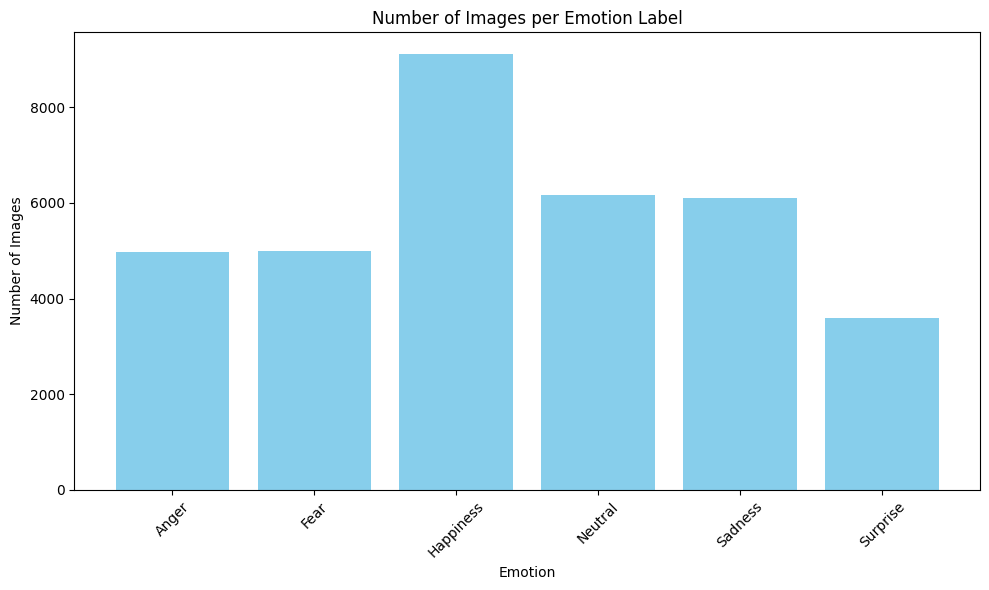

In [24]:
# Specify the input dataset file
dataset_file = 'images_labels_no_duplicates_no_dis_cont.pkl'

# Execute the verification function
plot_items_in_classes(dataset_file)

We could use the new function to randomly reduce the number of items in the Happiness class so it equals the Neutral class, then we can augment all classes to reach a cerain number of images.

## Data preprocessing, splitting, and augmentation

#### Random data reduction to reduce class imbalances

Even if random data reduction on majority classes would make classes much more balanced, we tested the smaller dataset, and the model underfits the data. There is why we are going to train with a bigger dataset for the moment, even if classes are less balanced.

In [87]:
input_pickle_file = "images_labels_no_duplicates_no_dis_cont.pkl"
output_pickle_file = "reduced_images_3.pkl"
#max_samples_per_class = 5003
max_samples_per_class = 9111

#Reduce majority classes
reduce_majority_classes(input_pickle_file, output_pickle_file, max_samples_per_class)

Stage: After loading in reduce_majority_classes
Number of images: 34945
Number of labels: 34945
Image shape: (48, 48)
Image dtype: float32
Unique labels: {'Anger', 'Happiness', 'Fear', 'Surprise', 'Neutral', 'Sadness'}
----
Stage: Before saving in reduce_majority_classes
Number of images: 34945
Number of labels: 34945
Image shape: (48, 48)
Image dtype: float32
Unique labels: {'Anger', 'Happiness', 'Fear', 'Surprise', 'Neutral', 'Sadness'}
----


#### Process and transform the data

In [88]:
input_pickle_file = "reduced_images_3.pkl"
output_pickle_file = "processed_images_3.pkl"

load_and_preprocess_images(input_pickle_file, output_pickle_file)

Stage: Preprocessed
Number of images: 34945
Number of labels: 34945
Image shape: (48, 48)
Image dtype: float32
Unique labels: {'Anger', 'Happiness', 'Fear', 'Surprise', 'Neutral', 'Sadness'}
----


#### Encode labels

In [89]:
#input_pickle_file = "reduced_images_3.pkl"
input_pickle_file = 'processed_images_3.pkl'
output_pickle_file = 'encoded_images.pkl'
label_mapping = 'label_mapping.pkl'
encode_labels(input_pickle_file, output_pickle_file, label_mapping)


Stage: After loading in encode_labels
Number of images: 34945
Number of labels: 34945
Image shape: (48, 48)
Image dtype: float32
Unique labels: {'Anger', 'Happiness', 'Fear', 'Surprise', 'Neutral', 'Sadness'}
----
Unique labels before encoding: {'Anger', 'Happiness', 'Fear', 'Surprise', 'Neutral', 'Sadness'}
Unique labels after encoding: {0, 1, 2, 3, 4, 5}
Stage: After encoding labels
Number of images: 34945
Number of labels: 34945
Image shape: (48, 48)
Image dtype: float32
Unique labels: {0, 1, 2, 3, 4, 5}
----
Label mapping saved:
{'label_to_int': {'Anger': 0, 'Fear': 1, 'Happiness': 2, 'Neutral': 3, 'Sadness': 4, 'Surprise': 5}, 'int_to_label': {0: 'Anger', 1: 'Fear', 2: 'Happiness', 3: 'Neutral', 4: 'Sadness', 5: 'Surprise'}}


#### Split the data

First of all we want to map the each label (string) into a corrresponding integer in a dictionary. Then we want to combine images and corresponding labels in separate lists and convert them into numpy arrays.

We want to sort the labels with a specific order (e.g., alphabetically), so each time we run the cell, we get the set of labels in the same order.

In [90]:
input_pickle_file = "encoded_images.pkl"
train_output_file = 'train_data_3.pkl'
val_output_file = 'val_data_3.pkl'
test_output_file = 'test_data_3.pkl'

torch.manual_seed(42)

#Split data into train, validation, and test sets
split_data(input_pickle_file, train_output_file, val_output_file, test_output_file)

Stage: After loading in split_data
Number of images: 34945
Number of labels: 34945
Image shape: (48, 48)
Image dtype: float32
Unique labels: {0, 1, 2, 3, 4, 5}
----
Stage: Train data in split_data
Number of images: 24461
Number of labels: 24461
Image shape: (48, 48)
Image dtype: float32
Unique labels: {0, 1, 2, 3, 4, 5}
----
Stage: Validation data in split_data
Number of images: 6290
Number of labels: 6290
Image shape: (48, 48)
Image dtype: float32
Unique labels: {0, 1, 2, 3, 4, 5}
----
Stage: Test data in split_data
Number of images: 4194
Number of labels: 4194
Image shape: (48, 48)
Image dtype: float32
Unique labels: {0, 1, 2, 3, 4, 5}
----


#### Convert sets into PIL files

Stage: Training Before Conversion to PIL
Number of images: 24461
Image shape: (48, 48)
Image dtype: float32
----


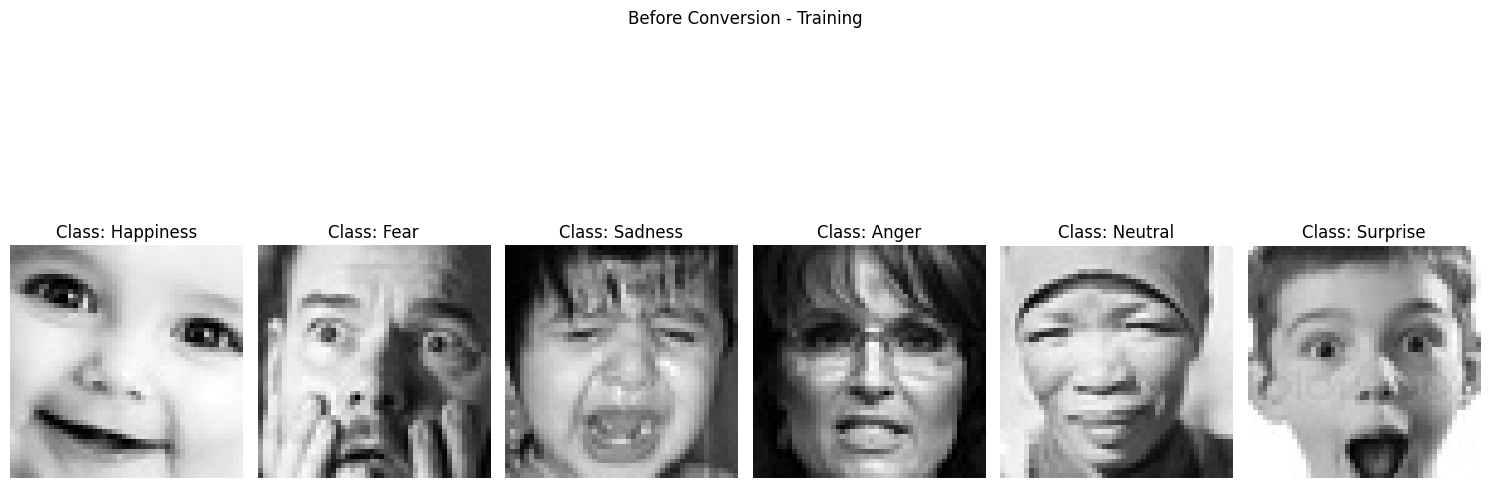

Stage: Training Converted to PIL
Number of images: 24461
Image size: (48, 48)
Image mode: L
----
Stage: Validation Before Conversion to PIL
Number of images: 6290
Image shape: (48, 48)
Image dtype: float32
----


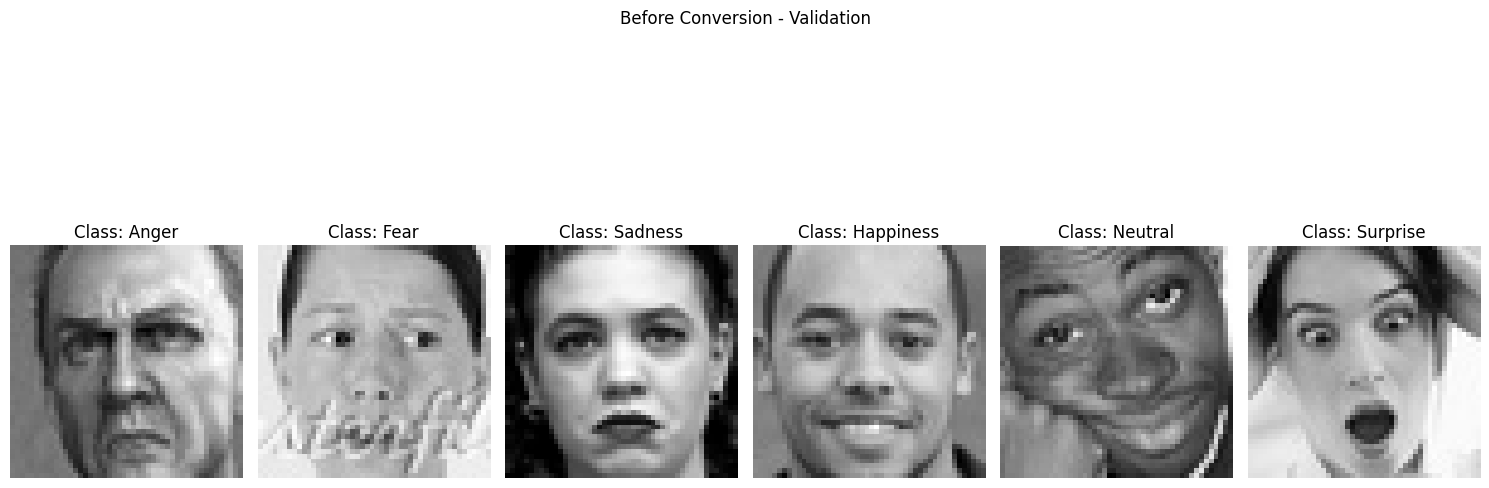

Stage: Validation Converted to PIL
Number of images: 6290
Image size: (48, 48)
Image mode: L
----
Stage: Test Before Conversion to PIL
Number of images: 4194
Image shape: (48, 48)
Image dtype: float32
----


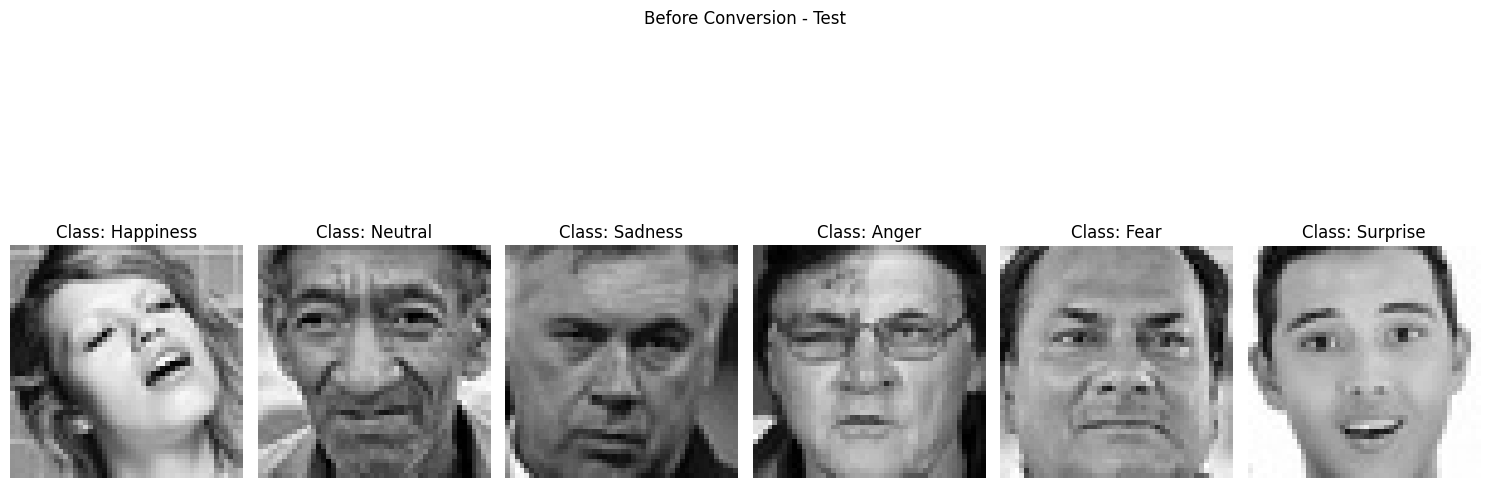

Stage: Test Converted to PIL
Number of images: 4194
Image size: (48, 48)
Image mode: L
----


In [91]:
training_set_pickle = 'train_data_3.pkl'
val_set_pickle= 'val_data_3.pkl'
test_set_pickle = 'test_data_3.pkl'

convert_to_pil(training_set_pickle, val_set_pickle, test_set_pickle)

#### Augment the training data

We are going to apply a 60-degree random rotation, in contrast to the 10-degree random rotation we applied in the previous notebook. This is because humans generally, when bending their neck on the side, they do so by 40 to 80 degrees. Therefore, 60 degrees looks like a good compromise.

In [92]:
input_pickle_file = 'pil_train_data.pkl'
output_pickle_file = 'pil_train_data_augmented_3.pkl'
#target_number_of_images = 8000
target_number_of_images = 10000

#Augment training data
balance_dataset(input_pickle_file, output_pickle_file, target_number_of_images)

Processing 0, 3484 images
Stage: Augmented
Number of images: 6516
Number of labels: 6516
Image size: (48, 48)
Image mode: L
Unique labels: {None}
----
0_balanced_images.pkl has been saved with 10000 images
Processing 1, 3502 images
Stage: Augmented
Number of images: 6498
Number of labels: 6498
Image size: (48, 48)
Image mode: L
Unique labels: {None}
----
1_balanced_images.pkl has been saved with 10000 images
Processing 2, 6378 images
Stage: Augmented
Number of images: 3622
Number of labels: 3622
Image size: (48, 48)
Image mode: L
Unique labels: {None}
----
2_balanced_images.pkl has been saved with 10000 images
Processing 3, 4308 images
Stage: Augmented
Number of images: 5692
Number of labels: 5692
Image size: (48, 48)
Image mode: L
Unique labels: {None}
----
3_balanced_images.pkl has been saved with 10000 images
Processing 4, 4270 images
Stage: Augmented
Number of images: 5730
Number of labels: 5730
Image size: (48, 48)
Image mode: L
Unique labels: {None}
----
4_balanced_images.pkl has

#### Convert back to numpy arrays

Stage: Training Converted back to a numpy array
Number of images: 60000
Image shape: (1, 48, 48)
Image dtype: float32
----


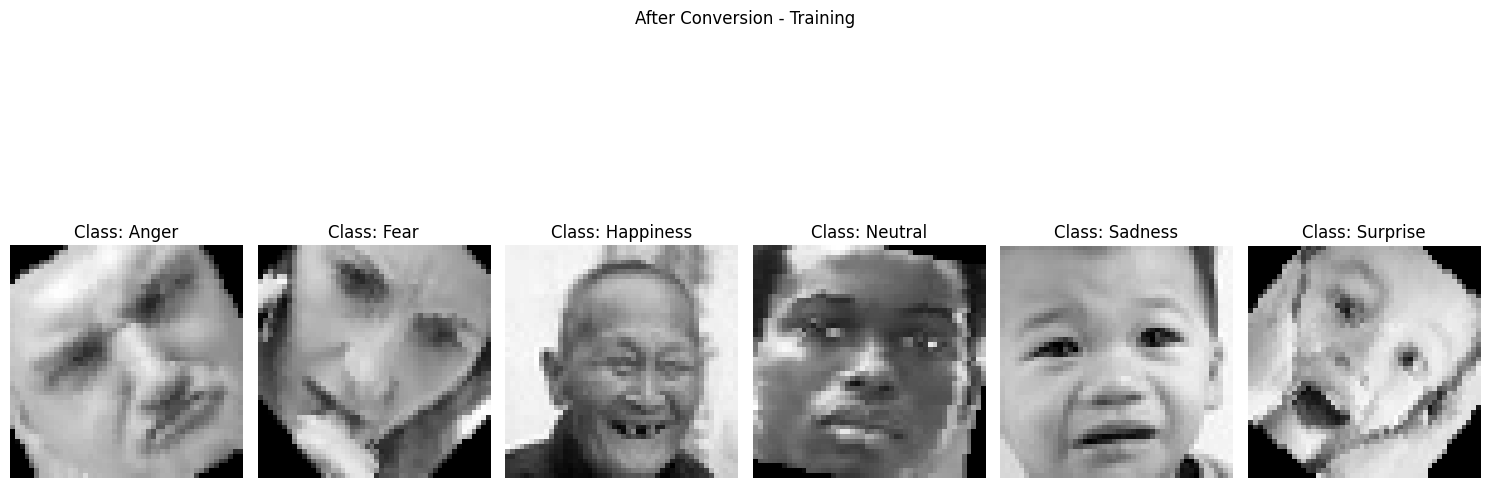

Stage: Validation Converted back to a numpy array
Number of images: 6290
Image shape: (1, 48, 48)
Image dtype: float32
----


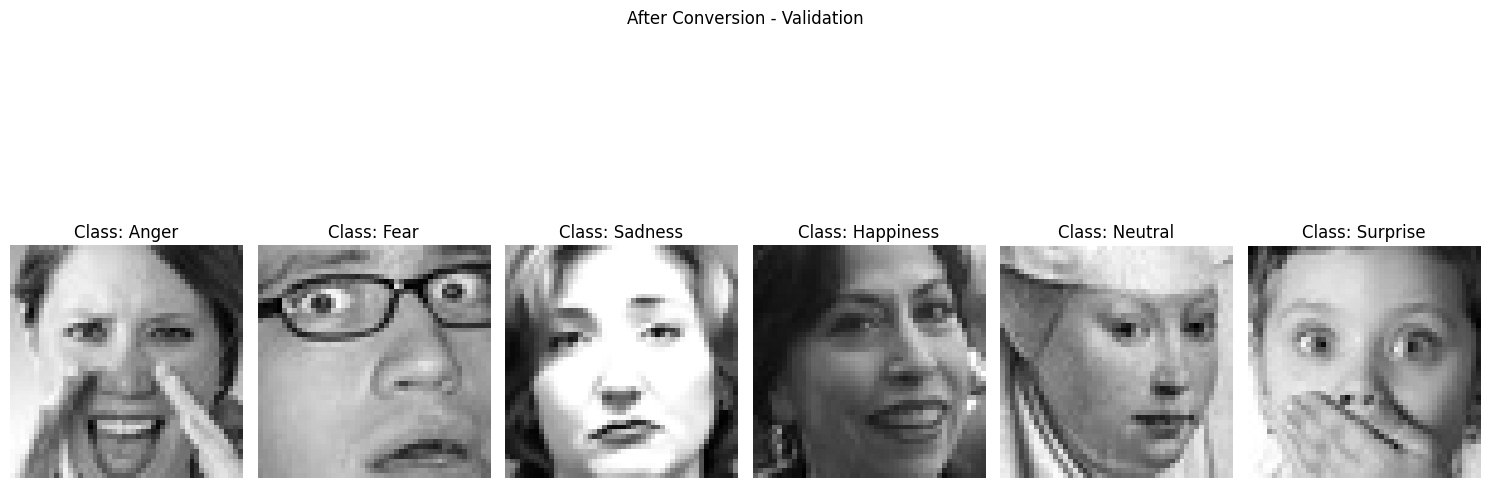

Stage: Test Converted back to a numpy array
Number of images: 4194
Image shape: (1, 48, 48)
Image dtype: float32
----


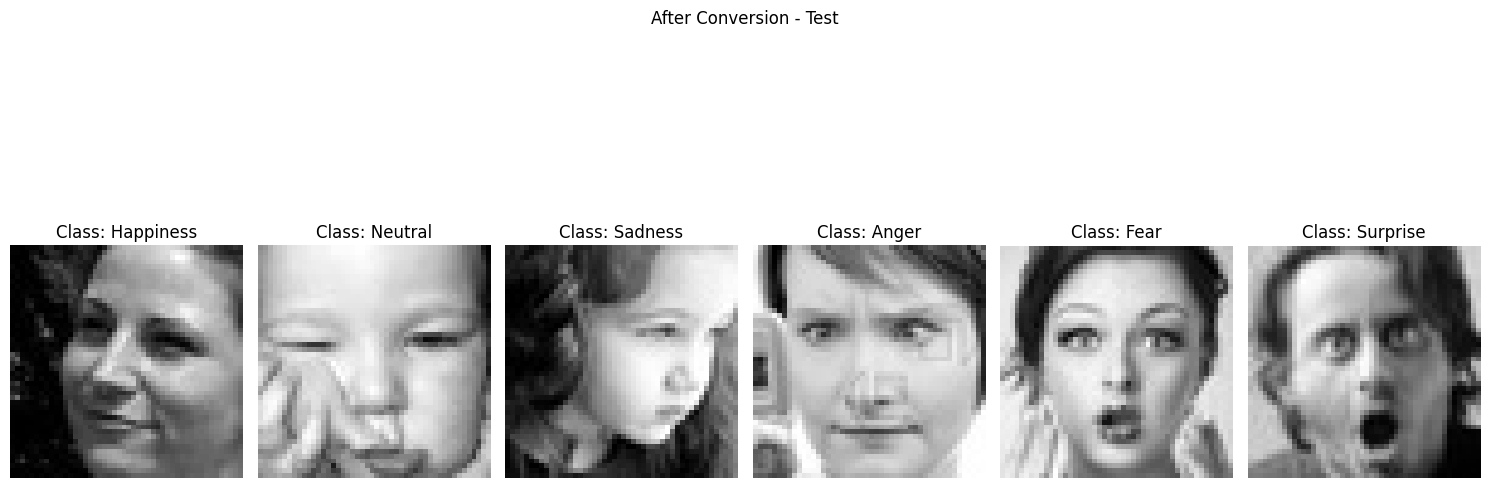

In [93]:
pil_augmented_train_data = 'pil_train_data_augmented_3.pkl'
pil_val_data = 'pil_val_data.pkl'
pil_test_data = 'pil_test_data.pkl'

convert_to_numpy_array(pil_augmented_train_data, pil_val_data, pil_test_data)

#### Verify the dataset and labels

Class: Anger, Image shape: (48, 48), dtype: float32, min: 0.0, max: 0.9803921580314636
Class: Fear, Image shape: (48, 48), dtype: float32, min: 0.0, max: 1.0
Class: Happiness, Image shape: (48, 48), dtype: float32, min: 0.04313725605607033, max: 1.0
Class: Neutral, Image shape: (48, 48), dtype: float32, min: 0.0, max: 1.0
Class: Sadness, Image shape: (48, 48), dtype: float32, min: 0.0, max: 0.7843137383460999
Class: Surprise, Image shape: (48, 48), dtype: float32, min: 0.0, max: 0.8980392217636108


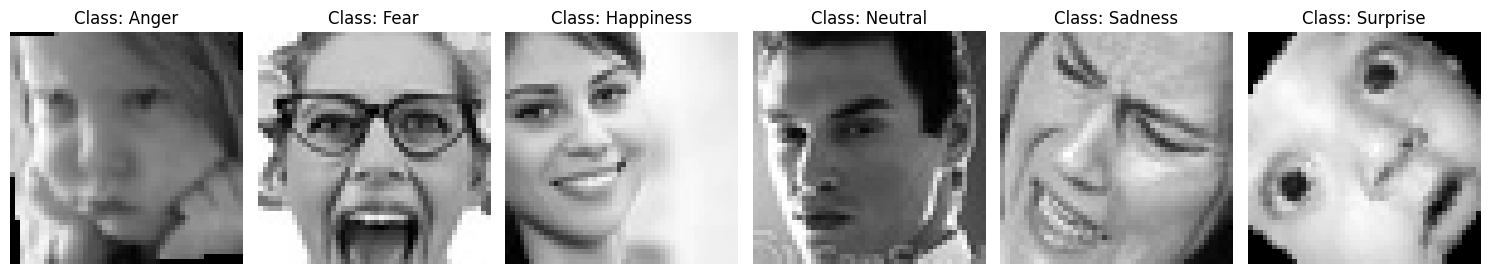

In [94]:
# Load the data from the pickle file
dataset_file = 'numpy_train_data.pkl'

verify_images(dataset_file)

Class: Anger, Image shape: (48, 48), dtype: float32, min: 0.0117647061124444, max: 1.0
Class: Fear, Image shape: (48, 48), dtype: float32, min: 0.11764705926179886, max: 0.9529411792755127
Class: Happiness, Image shape: (48, 48), dtype: float32, min: 0.0, max: 0.7411764860153198
Class: Surprise, Image shape: (48, 48), dtype: float32, min: 0.0, max: 0.95686274766922
Class: Neutral, Image shape: (48, 48), dtype: float32, min: 0.0235294122248888, max: 0.886274516582489
Class: Sadness, Image shape: (48, 48), dtype: float32, min: 0.0, max: 0.9803921580314636


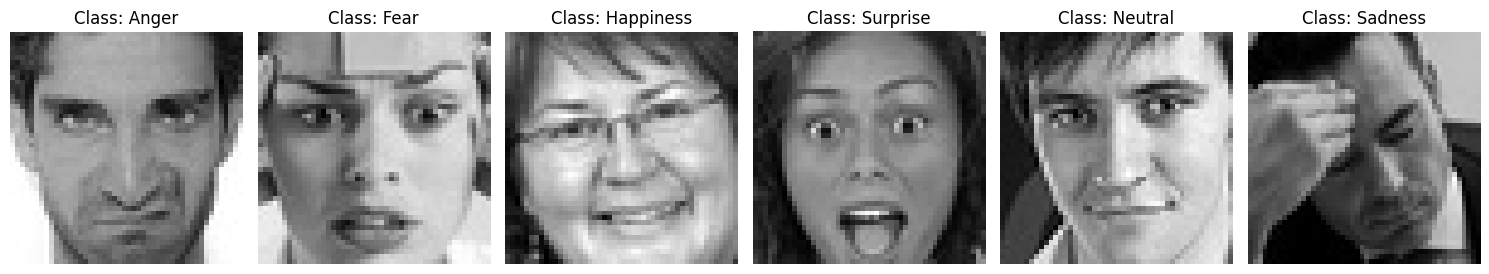

In [53]:
# Load the data from the pickle file
dataset_file = 'numpy_val_data.pkl'

verify_images(dataset_file)

Class: Fear, Image shape: (48, 48), dtype: float32, min: 0.007843137718737125, max: 1.0
Class: Anger, Image shape: (48, 48), dtype: float32, min: 0.0, max: 0.9960784316062927
Class: Sadness, Image shape: (48, 48), dtype: float32, min: 0.0, max: 0.8784313797950745
Class: Happiness, Image shape: (48, 48), dtype: float32, min: 0.0, max: 0.9333333373069763
Class: Neutral, Image shape: (48, 48), dtype: float32, min: 0.003921568859368563, max: 1.0
Class: Surprise, Image shape: (48, 48), dtype: float32, min: 0.0, max: 0.9058823585510254


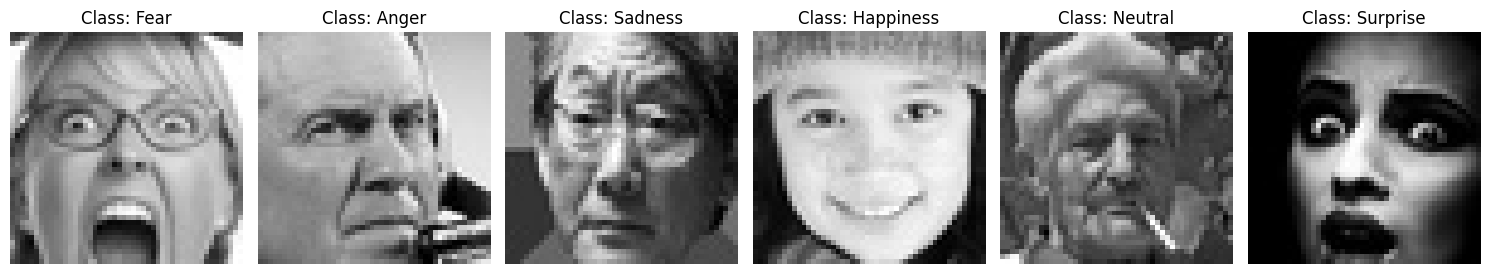

In [54]:
# Load the data from the pickle file
dataset_file = 'numpy_test_data.pkl'

verify_images(dataset_file)

It looks like the data has been uploaded correctly.

## Load the data and define the dataloaders

As a final step we want to create dataloaders, which are utilities responsible of loading the data into the model in batches. We have also saved each dataset into a pickle file, so we can easily load them without having to run the code above each time we open this notebook.

In [95]:
# Load the data from a pickle file
#train_dataset = pd.read_pickle('train_data_augmented_3.pkl')
train_dataset = pd.read_pickle('numpy_train_data.pkl')
#train_dataset_original = pd.read_pickle('train_data_3.pkl')
val_dataset = pd.read_pickle('numpy_val_data.pkl')
test_dataset = pd.read_pickle('numpy_test_data.pkl')
label_mapping = pd.read_pickle('label_mapping.pkl')

In [ ]:
# Inspect the structure of the datasets
print("Train Dataset Type:", type(train_dataset))
print("Train Dataset Sample:", train_dataset[:2])  # Print first 2 items for inspection

print("Validation Dataset Type:", type(val_dataset))
print("Validation Dataset Sample:", val_dataset[:2])  # Print first 2 items for inspection

print("Test Dataset Type:", type(test_dataset))
print("Test Dataset Sample:", test_dataset[:2])  # Print first 2 items for inspection

In [97]:
# Convert the datasets to TensorDatasets
train_tensors = convert_to_tensors(train_dataset[0], train_dataset[1])
val_tensors = convert_to_tensors(val_dataset[0], val_dataset[1])
test_tensors = convert_to_tensors(test_dataset[0], test_dataset[1])

# Save the converted datasets to new pickle files
#save_dataset_to_pickle(train_tensors, 'train_data_augmented_3_tensors.pkl')
save_dataset_to_pickle(train_tensors, 'train_data_3_tensors.pkl')
save_dataset_to_pickle(val_tensors, 'val_data_3_tensors.pkl')
save_dataset_to_pickle(test_tensors, 'test_data_3_tensors.pkl')

In [10]:
# Load the datasets for our models
#train_tensors = pd.read_pickle('train_data_augmented_3_tensors.pkl')
train_tensors = pd.read_pickle('train_data_3_tensors.pkl')
val_tensors = pd.read_pickle('val_data_3_tensors.pkl')
test_tensors = pd.read_pickle('test_data_3_tensors.pkl')

In [11]:
# Create DataLoaders for each set
train_loader = DataLoader(train_tensors, batch_size=32, shuffle=True)
val_loader = DataLoader(val_tensors, batch_size=32, shuffle=False)
test_loader = DataLoader(test_tensors, batch_size=32, shuffle=False)

## Build the models

We are loading the architectures of the best performing models of our [previous notebook](https://www.kaggle.com/code/gabrielenoaro/emotion-classification-from-faces-with-cnn-part-2), and below you can find a summary of the reasoning behind those models.

Even if the images are small, we want to be able to capture details and microexpressions, so we are adding 4 convolutional layers to the model. This number can be empirically adjusted. Too many convolutional layers will lead to overfitting, while too few convolutional layers will lead to underfitting.

We want to make a deep learning model and add a few hidden layers to capture more complex relationships and patterns. Precisely, whereas convolutional layers focus on feature extraction by applying convolution operations on input data, hidden layers focus on transforming and learning representations from these extracted features. 

#### Model 26

In [65]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.conv6 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(1024)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.dropout1 = nn.Dropout(p=0.25)
        self.dropout2 = nn.Dropout(p=0.25)
        self.dropout3 = nn.Dropout(p=0.25)
        self.dropout4 = nn.Dropout(p=0.25)
        self.dropout5 = nn.Dropout(p=0.25)
        self.dropout6 = nn.Dropout(p=0.25)
        self.dropout7 = nn.Dropout(p=0.25)
        self.dropout8 = nn.Dropout(p=0.25)
        self.dropout9 = nn.Dropout(p=0.25)
        self.dropout10 = nn.Dropout(p=0.25)
        self.dropout11 = nn.Dropout(p=0.25)
        
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, 16)
        self.fc7 = nn.Linear(16, 6)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = self.dropout1(x)
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.dropout2(x)
        
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = self.dropout3(x)
        
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)
        x = self.dropout4(x)
        
        x = F.relu(self.bn5(self.conv5(x)))
        x = self.dropout5(x)
        
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.dropout6(x)
        
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.fc1(x))
        x = self.dropout7(x)
        x = F.relu(self.fc2(x))
        x = self.dropout8(x)
        x = F.relu(self.fc3(x))
        x = self.dropout9(x)
        x = F.relu(self.fc4(x))
        x = self.dropout10(x)
        x = F.relu(self.fc5(x))
        x = self.dropout11(x)
        x = F.relu(self.fc6(x))
        x = self.fc7(x)
        
        return x

In [66]:
model_26 = CNNModel()

# Select between 'cpu' or 'cuda' to access GPU
#device = 'cpu' # Select between 'cpu' or 'cuda' to access GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# Move the model to the selected device
model_26.to(device)

# Summarize the model
summary(model_26, input_size=(1, 48, 48), batch_size=1, device=device)

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [1, 32, 48, 48]             320
       BatchNorm2d-2            [1, 32, 48, 48]              64
         MaxPool2d-3            [1, 32, 24, 24]               0
           Dropout-4            [1, 32, 24, 24]               0
            Conv2d-5            [1, 64, 24, 24]          18,496
       BatchNorm2d-6            [1, 64, 24, 24]             128
         MaxPool2d-7            [1, 64, 12, 12]               0
           Dropout-8            [1, 64, 12, 12]               0
            Conv2d-9           [1, 128, 12, 12]          73,856
      BatchNorm2d-10           [1, 128, 12, 12]             256
        MaxPool2d-11             [1, 128, 6, 6]               0
          Dropout-12             [1, 128, 6, 6]               0
           Conv2d-13             [1, 256, 6, 6]         295,168
      BatchNorm2d-14             [

#### Model 33

In [67]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        # Define the layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(p=0.5)
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.dropout2 = nn.Dropout(p=0.5)
        
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        
        self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(256)
        self.dropout3 = nn.Dropout(p=0.5)
        
        self.fc1 = nn.Linear(256 * 6 * 6, 128)
        self.bn7 = nn.BatchNorm1d(128)
        self.dropout4 = nn.Dropout(p=0.5)
        
        self.out = nn.Linear(128, 6)  # Change the number of output channels to 8
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.dropout1(x)
        
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)
        x = self.dropout2(x)
        
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.pool(x)
        x = self.dropout3(x)
        
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = F.relu(self.bn7(self.fc1(x)))
        x = self.dropout4(x)
        x = self.out(x)
        
        return x

In [68]:
model_33 = CNNModel()
# Saying DCNN and CNN is the same. This is just to sematincally indicate that we are talking about a deep convolutional neural network.
# We will stick with CNN for consistency, and the models are still being considered as DCNNs.

# Select between 'cpu' or 'cuda' to access GPU
#device = 'cpu' # Select between 'cpu' or 'cuda' to access GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# Move the model to the selected device
model_33.to(device)

# Summarize the model
summary(model_33, input_size=(1, 48, 48), batch_size=1, device=device)

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [1, 64, 48, 48]             640
       BatchNorm2d-2            [1, 64, 48, 48]             128
            Conv2d-3            [1, 64, 48, 48]          36,928
       BatchNorm2d-4            [1, 64, 48, 48]             128
         MaxPool2d-5            [1, 64, 24, 24]               0
           Dropout-6            [1, 64, 24, 24]               0
            Conv2d-7           [1, 128, 24, 24]          73,856
       BatchNorm2d-8           [1, 128, 24, 24]             256
            Conv2d-9           [1, 128, 24, 24]         147,584
      BatchNorm2d-10           [1, 128, 24, 24]             256
        MaxPool2d-11           [1, 128, 12, 12]               0
          Dropout-12           [1, 128, 12, 12]               0
           Conv2d-13           [1, 256, 12, 12]         295,168
      BatchNorm2d-14           [1,

#### Model 36

In [69]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        
        self.conv6 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(1024)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        self.dropout = nn.Dropout(p=0.25)
        
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, 16)
        self.fc7 = nn.Linear(16, 10)
        self.fc8 = nn.Linear(10, 6)   # Final layer matching the number of classes

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = self.dropout(x)
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.dropout(x)
        
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = self.dropout(x)
        
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)
        x = self.dropout(x)
        
        x = F.relu(self.bn5(self.conv5(x)))
        x = self.dropout(x)
        
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.dropout(x)
        
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        
        x = F.relu(self.fc4(x))
        x = self.dropout(x)
        
        x = F.relu(self.fc5(x))
        x = self.dropout(x)
        
        x = F.relu(self.fc6(x))
        x = F.relu(self.fc7(x))
        x = self.fc8(x)
        
        return x


In [70]:
model_36 = CNNModel()

# Select between 'cpu' or 'cuda' to access GPU
#device = 'cpu' # Select between 'cpu' or 'cuda' to access GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# Move the model to the selected device
model_36.to(device)

# Summarize the model
summary(model_36, input_size=(1, 48, 48), batch_size=1, device=device)

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [1, 32, 48, 48]             320
       BatchNorm2d-2            [1, 32, 48, 48]              64
         MaxPool2d-3            [1, 32, 24, 24]               0
           Dropout-4            [1, 32, 24, 24]               0
            Conv2d-5            [1, 64, 24, 24]          18,496
       BatchNorm2d-6            [1, 64, 24, 24]             128
         MaxPool2d-7            [1, 64, 12, 12]               0
           Dropout-8            [1, 64, 12, 12]               0
            Conv2d-9           [1, 128, 12, 12]          73,856
      BatchNorm2d-10           [1, 128, 12, 12]             256
        MaxPool2d-11             [1, 128, 6, 6]               0
          Dropout-12             [1, 128, 6, 6]               0
           Conv2d-13             [1, 256, 6, 6]         295,168
      BatchNorm2d-14             [

#### Model 37

In [71]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        
        self.conv6 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(1024)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        self.dropout = nn.Dropout(p=0.25)
        
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, 16)
        self.fc7 = nn.Linear(16, 10)
        self.fc8 = nn.Linear(10, 6)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = self.dropout(x)
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = self.dropout(x)
        
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)
        
        x = F.relu(self.bn5(self.conv5(x)))
        x = self.dropout(x)
        
        x = F.relu(self.bn6(self.conv6(x)))
        
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        
        x = F.relu(self.fc2(x))
        
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        
        x = F.relu(self.fc4(x))
        
        x = F.relu(self.fc5(x))
        x = self.dropout(x)
        
        x = F.relu(self.fc6(x))
        x = F.relu(self.fc7(x))
        x = self.fc8(x)
        
        return x


In [72]:
model_37 = CNNModel()

# Select between 'cpu' or 'cuda' to access GPU
#device = 'cpu' # Select between 'cpu' or 'cuda' to access GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# Move the model to the selected device
model_37.to(device)

# Summarize the model
summary(model_37, input_size=(1, 48, 48), batch_size=1, device=device)

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [1, 32, 48, 48]             320
       BatchNorm2d-2            [1, 32, 48, 48]              64
         MaxPool2d-3            [1, 32, 24, 24]               0
           Dropout-4            [1, 32, 24, 24]               0
            Conv2d-5            [1, 64, 24, 24]          18,496
       BatchNorm2d-6            [1, 64, 24, 24]             128
         MaxPool2d-7            [1, 64, 12, 12]               0
            Conv2d-8           [1, 128, 12, 12]          73,856
       BatchNorm2d-9           [1, 128, 12, 12]             256
        MaxPool2d-10             [1, 128, 6, 6]               0
          Dropout-11             [1, 128, 6, 6]               0
           Conv2d-12             [1, 256, 6, 6]         295,168
      BatchNorm2d-13             [1, 256, 6, 6]             512
        MaxPool2d-14             [

#### Model 38

In [109]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(p=0.25)
        self.dropout2 = nn.Dropout(p=0.25)

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, 6)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = self.dropout1(x)
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.dropout2(x)
        
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x



In [110]:
model_38 = CNNModel()

# Select between 'cpu' or 'cuda' to access GPU
#device = 'cpu' # Select between 'cpu' or 'cuda' to access GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# Move the model to the selected device
model_38.to(device)

# Summarize the model
summary(model_38, input_size=(1, 48, 48), batch_size=1, device=device)

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [1, 32, 48, 48]             320
       BatchNorm2d-2            [1, 32, 48, 48]              64
         MaxPool2d-3            [1, 32, 24, 24]               0
           Dropout-4            [1, 32, 24, 24]               0
            Conv2d-5            [1, 64, 24, 24]          18,496
       BatchNorm2d-6            [1, 64, 24, 24]             128
         MaxPool2d-7            [1, 64, 12, 12]               0
           Dropout-8            [1, 64, 12, 12]               0
 AdaptiveAvgPool2d-9              [1, 64, 1, 1]               0
           Linear-10                    [1, 32]           2,080
           Linear-11                     [1, 6]             198
Total params: 21,286
Trainable params: 21,286
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forwa

#### Model 39

In [12]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, 6)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

In [13]:
model_39 = CNNModel()

# Select between 'cpu' or 'cuda' to access GPU
#device = 'cpu' # Select between 'cpu' or 'cuda' to access GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# Move the model to the selected device
model_39.to(device)

# Summarize the model
summary(model_39, input_size=(1, 48, 48), batch_size=1, device=device)

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [1, 32, 48, 48]             320
       BatchNorm2d-2            [1, 32, 48, 48]              64
         MaxPool2d-3            [1, 32, 24, 24]               0
            Conv2d-4            [1, 64, 24, 24]          18,496
       BatchNorm2d-5            [1, 64, 24, 24]             128
         MaxPool2d-6            [1, 64, 12, 12]               0
 AdaptiveAvgPool2d-7              [1, 64, 1, 1]               0
            Linear-8                    [1, 32]           2,080
            Linear-9                     [1, 6]             198
Total params: 21,286
Trainable params: 21,286
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 1.90
Params size (MB): 0.08
Estimated Total Size (MB): 1.99
----------------------------------------

## Train and test the models

### Define the hyperparameters

In [19]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Early stopping parameters
patience = 5  # Number of epochs to wait for improvement
checkpoint_interval = 100  # Save model weights every 5 epochs

# Set number of epochs
num_epochs = 100

In case you opened the book and loaded the data train, test, and validation data from a picke file without going over the first part of the notebook, define the dataloaders here.

In [107]:
# Create DataLoaders for each set
train_loader = DataLoader(train_tensors, batch_size=32, shuffle=True)
val_loader = DataLoader(val_tensors, batch_size=32, shuffle=False)
test_loader = DataLoader(test_tensors, batch_size=32, shuffle=False)

### Helper functions for training, testing, and plotting

#### Train the models

In [15]:
#Train the model
def train_model(model, model_name, criterion, optimizer, train_loader,
                val_loader, device, num_epochs, patience,
                checkpoint_interval):
    """
    Args:
    - model (torch.nn.Module): The neural network model to be trained.
    - model_name (str): The name to use for saving the model and accuracies.
    - criterion (torch.nn.modules.loss._Loss): The loss function used for training.
    - optimizer (torch.optim.Optimizer): The optimizer used for training.
    - train_loader (torch.utils.data.DataLoader): DataLoader for the training dataset.
    - val_loader (torch.utils.data.DataLoader): DataLoader for the validation dataset.
    - device (torch.device): Device (cpu or cuda) on which to perform computations.
    - num_epochs (int): Number of epochs to train the model.
    - patience (int): Number of epochs to wait for improvement in validation accuracy before stopping early.
    - checkpoint_interval (int): Interval (in epochs) at which to save model checkpoints.

    Returns:
    - train_losses (list): List of training losses for each epoch.
    - train_accuracies (list): List of training accuracies for each epoch.
    - val_losses (list): List of validation losses for each epoch.
    - val_accuracies (list): List of validation accuracies for each epoch.
    """
    model = model.to(device)
    model.train()  # Set the model to training mode

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    best_val_accuracy = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())
    epochs_without_improvement = 0

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_train_accuracy = 100 * correct / total
        train_accuracies.append(epoch_train_accuracy)
        train_losses.append(running_loss / len(train_loader))

        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {train_losses[-1]}, Accuracy: {epoch_train_accuracy}%')

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        epoch_val_accuracy = 100 * correct / total
        val_accuracies.append(epoch_val_accuracy)
        val_losses.append(val_loss / len(val_loader))

        print(f'Validation Loss: {val_losses[-1]}, Accuracy: {epoch_val_accuracy}%')

        # Check for early stopping
        if epoch_val_accuracy > best_val_accuracy:
            best_val_accuracy = epoch_val_accuracy
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            print(f'Early stopping at epoch {epoch + 1}. Best validation accuracy: {best_val_accuracy}%')
            model.load_state_dict(best_model_wts)
            break

        # Save model checkpoint every checkpoint_interval epochs
        if (epoch + 1) % checkpoint_interval == 0:
            checkpoint_filename = f'{model_name}_checkpoint_epoch_{epoch + 1}.pth'
            torch.save(model.state_dict(), checkpoint_filename)
            print(f'Checkpoint saved at epoch {epoch + 1}')

    # Load the best model weights before early stopping
    model.load_state_dict(best_model_wts)

    # Save the best model weights
    model_filename = f'{model_name}_best_model.pth'
    torch.save(model.state_dict(), model_filename)
    print(f'Best model saved as {model_filename}')

    # Save the accuracies and model name
    with open(f'{model_name}_accuracies.pkl', 'wb') as f:
        pickle.dump((model_name, train_accuracies, val_accuracies), f)

    return train_losses, train_accuracies, val_losses, val_accuracies



#### Test the models

In [14]:
#Test the model
def evaluate_model(model, criterion, test_loader, device, model_name):
    """
    Args:
    - model (torch.nn.Module): The trained neural network model.
    - criterion (torch.nn.modules.loss._Loss): The loss function used for training.
    - test_loader (torch.utils.data.DataLoader): DataLoader for the test dataset.
    - device (torch.device): Device (cpu or cuda) on which to perform computations.
    - model_name (str): The name or identifier of the model.

    Returns:
    - test_loss (float): Average loss on the test set.
    - test_accuracy (float): Accuracy on the test set.
    """
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to the appropriate device

            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Calculate loss

            test_loss += loss.item()  # Accumulate test loss

            _, predicted = torch.max(outputs.data, 1)  # Get predictions
            total += labels.size(0)  # Total number of labels
            correct += (predicted == labels).sum().item()  # Count correct predictions

    test_accuracy = 100 * correct / total

    # Save the test results in a pickle file
    test_results = {
        'test_loss': test_loss / len(test_loader),
        'test_accuracy': test_accuracy
    }
    output_pickle_file = f'{model_name}_test_results.pkl'
    with open(output_pickle_file, 'wb') as f:
        pickle.dump(test_results, f)

    return test_loss / len(test_loader), test_accuracy

#### Plot the performance of the training across epochs

In [16]:
# Plot the model performance after training
def plot_training_progress(training_results):
  
    """
    Plot training and validation accuracies across epochs for multiple models.

    Args:
    - training_results (list of tuples): List of tuples containing model names and their respective training and validation accuracies.
      Each tuple should be in the form: (model_name, train_accuracies, val_accuracies).
    """
    plt.figure(figsize=(10, 5))
    
    # Plot training and validation accuracies
    for result in training_results:
        model_name, train_accuracies, val_accuracies = result
        epochs = range(1, len(train_accuracies) + 1)
        plt.plot(epochs, train_accuracies, label=f'Training Accuracy - {model_name}')
        plt.plot(epochs, val_accuracies, label=f'Validation Accuracy - {model_name}')
    
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy Comparison')
    plt.legend()
    plt.grid(True)
    plt.show()
    

### Train the models

#### Train Model 26

In [77]:
"""
Model 26 was originally trained with optimizer_16.
However, we can try also lowering the learning rate to 0.001 for increased stability,
and beta 1 to 0.9 to reduce overfitting, even if this may lead the model to get stuck in a local minima.
"""

optimizer_16 = lambda params: optim.Adam(params, lr=0.003, betas=(0.999, 0.999), weight_decay=0.0003)
optimizer_20 = lambda params: optim.Adam(params, lr=0.001, betas=(0.9, 0.999), weight_decay=0.0003)
optimizer_21 = lambda params: optim.Adam(params, lr=0.01, betas=(0.999, 0.999), weight_decay=0.000001)

In [102]:
train_model(model=model_26, model_name="Model_26", criterion=criterion, optimizer=optimizer_21(model_26.parameters()),
            train_loader=train_loader, val_loader=val_loader, device=device,
            num_epochs=200, patience=5, checkpoint_interval=checkpoint_interval)

Epoch [1/200], Loss: 1.789044181505839, Accuracy: 18.22833333333333%
Validation Loss: 1.7819731822473748, Accuracy: 14.753577106518282%
Epoch [2/200], Loss: 1.7930922193527221, Accuracy: 16.721666666666668%
Validation Loss: 1.790323310092016, Accuracy: 14.24483306836248%
Epoch [3/200], Loss: 1.7931571266174315, Accuracy: 16.756666666666668%
Validation Loss: 1.7901854920508293, Accuracy: 17.456279809220987%
Epoch [4/200], Loss: 1.79288741162618, Accuracy: 16.875%
Validation Loss: 1.804229942070046, Accuracy: 14.24483306836248%
Epoch [5/200], Loss: 1.7929121088663738, Accuracy: 16.626666666666665%
Validation Loss: 1.7904617774305005, Accuracy: 26.073131955484897%
Epoch [6/200], Loss: 1.792905795987447, Accuracy: 16.58%
Validation Loss: 1.7923377443691195, Accuracy: 17.615262321144673%
Epoch [7/200], Loss: 33.65944467271169, Accuracy: 16.761666666666667%
Validation Loss: 1.7896359928973435, Accuracy: 14.24483306836248%
Epoch [8/200], Loss: 3982.962528460312, Accuracy: 16.723333333333333%


([1.789044181505839,
  1.7930922193527221,
  1.7931571266174315,
  1.79288741162618,
  1.7929121088663738,
  1.792905795987447,
  33.65944467271169,
  3982.962528460312,
  5140.040865332349,
  1.7923461236317952],
 [18.22833333333333,
  16.721666666666668,
  16.756666666666668,
  16.875,
  16.626666666666665,
  16.58,
  16.761666666666667,
  16.723333333333333,
  16.528333333333332,
  16.676666666666666],
 [1.7819731822473748,
  1.790323310092016,
  1.7901854920508293,
  1.804229942070046,
  1.7904617774305005,
  1.7923377443691195,
  1.7896359928973435,
  1.7952659777578364,
  1.7960131307543836,
  1.7945587314324936],
 [14.753577106518282,
  14.24483306836248,
  17.456279809220987,
  14.24483306836248,
  26.073131955484897,
  17.615262321144673,
  14.24483306836248,
  10.302066772655008,
  14.24483306836248,
  17.456279809220987])

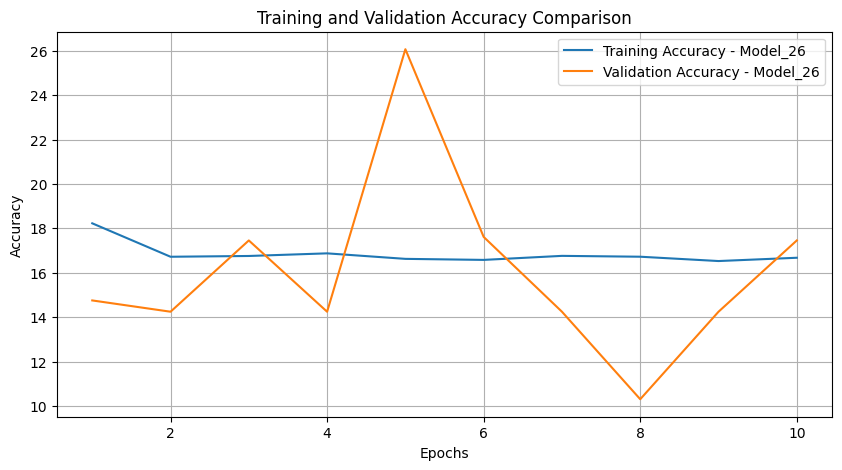

In [103]:
model_name ="Model_26"

# Load the accuracies from the file
with open(f"{model_name}_accuracies.pkl", "rb") as f:
    model_name, train_accuracies, val_accuracies = pickle.load(f)

# Define training results
training_results = [
    (model_name, train_accuracies, val_accuracies)
    # Add more models if needed
]

# Plot the training progress
plot_training_progress(training_results)

It looks like the model is to complex for the data we have, so the model is underffitting the data.

#### Train model_33

Since model_32 responded well to optimizer_18, but still overfitted quite a bit, we created a new optimizer by reducing beta 1 and doubling the weight decay to 0.001.

In [106]:
optimizer_21 = lambda params: optim.Adam(params, lr=0.01, betas=(0.999, 0.999), weight_decay=0.000001)
optimizer_19 = lambda params: optim.Adam(params, lr=0.001, betas=(0.9, 0.999), weight_decay=0.001)

In [108]:
train_model(model=model_33, model_name="Model_33", criterion=criterion, optimizer=optimizer_19(model_33.parameters()),
            train_loader=train_loader, val_loader=val_loader, device=device,
            num_epochs=200, patience=5, checkpoint_interval=checkpoint_interval)

Epoch [1/200], Loss: 1.5809336181640625, Accuracy: 34.765%
Validation Loss: 1.350946977053802, Accuracy: 48.028616852146264%
Epoch [2/200], Loss: 1.5017848836898804, Accuracy: 38.78%
Validation Loss: 1.449220545400823, Accuracy: 43.94276629570747%
Epoch [3/200], Loss: 1.540778915087382, Accuracy: 36.72833333333333%
Validation Loss: 1.4515148619104763, Accuracy: 40.90620031796502%
Epoch [4/200], Loss: 1.5060245493570963, Accuracy: 38.81333333333333%
Validation Loss: 1.3819694670323792, Accuracy: 44.992050874403816%
Epoch [5/200], Loss: 1.476369884554545, Accuracy: 39.901666666666664%
Validation Loss: 1.3536252007266592, Accuracy: 45.89825119236884%
Epoch [6/200], Loss: 1.450380624294281, Accuracy: 41.55833333333333%
Validation Loss: 1.334971361959041, Accuracy: 48.04451510333863%
Epoch [7/200], Loss: 1.4219822598457337, Accuracy: 42.46333333333333%
Validation Loss: 1.3068275975091808, Accuracy: 48.267090620031794%
Epoch [8/200], Loss: 1.4012584224700928, Accuracy: 43.455%
Validation Los

([1.5809336181640625,
  1.5017848836898804,
  1.540778915087382,
  1.5060245493570963,
  1.476369884554545,
  1.450380624294281,
  1.4219822598457337,
  1.4012584224700928,
  1.4829839211463929,
  1.7235147837320963,
  1.567158978398641,
  1.4814994434992472,
  1.43687191212972,
  1.3966938632965087,
  1.3719516699473062,
  1.348419719473521,
  1.3312565806070964,
  1.3157301700274149,
  1.311555940914154,
  1.3272787912368775,
  1.2863159443537395,
  1.2801272056261699,
  1.268827912425995,
  1.2614221345583598,
  1.261762975247701,
  1.2494666833877563,
  1.2537219571431477,
  1.242392093340556,
  1.2388692812919617,
  1.231878585211436,
  1.229922082424164,
  1.2287133044878642,
  1.2399266054789224],
 [34.765,
  38.78,
  36.72833333333333,
  38.81333333333333,
  39.901666666666664,
  41.55833333333333,
  42.46333333333333,
  43.455,
  40.85333333333333,
  24.63,
  34.873333333333335,
  39.556666666666665,
  41.74,
  43.54833333333333,
  44.92333333333333,
  45.846666666666664,
  46

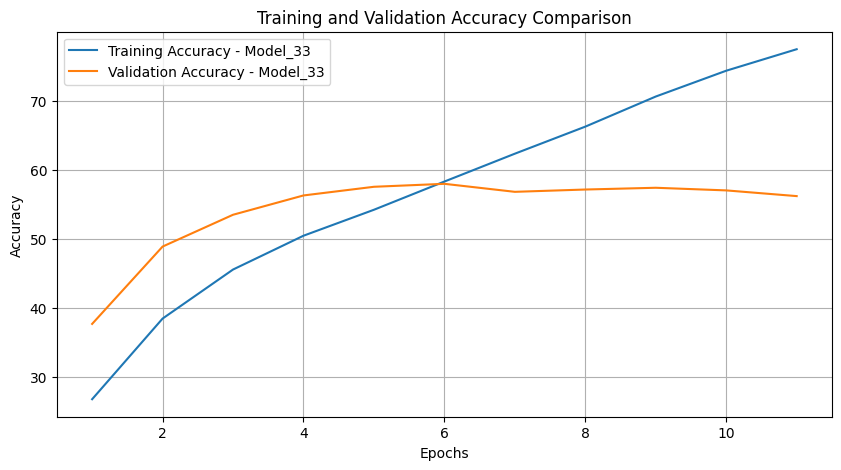

In [101]:
model_name ="Model_33"

# Load the accuracies from the file
with open(f"{model_name}_accuracies.pkl", "rb") as f:
    model_name, train_accuracies, val_accuracies = pickle.load(f)

# Define training results
training_results = [
    (model_name, train_accuracies, val_accuracies)
    # Add more models if needed
]

# Plot the training progress
plot_training_progress(training_results)

Training accuracy rises more slowly at the beginning because the training set is harder to learn on due to the data augmentation. We can consider stopping the training once the training accuracy crosses and surpasses the validation accuracy.

#### Train model_36

In [39]:
optimizer_22 = lambda params: optim.Adam(params, lr=0.01, betas=(0.999, 0.999), weight_decay=0.0000001)


In [40]:
train_model(model=model_36, model_name="Model_36", criterion=criterion, optimizer=optimizer_22(model_36.parameters()),
            train_loader=train_loader, val_loader=val_loader, device=device,
            num_epochs=200, patience=5, checkpoint_interval=checkpoint_interval)

Epoch [1/200], Loss: 1.754278371536654, Accuracy: 25.743019500429256%
Validation Loss: 1.7528596087760733, Accuracy: 26.073131955484897%
Epoch [2/200], Loss: 1.75275734327977, Accuracy: 26.07415886513225%
Validation Loss: 1.7523001390060193, Accuracy: 26.073131955484897%
Epoch [3/200], Loss: 1.7525722350949555, Accuracy: 26.07415886513225%
Validation Loss: 1.7523237291326377, Accuracy: 26.073131955484897%
Epoch [4/200], Loss: 1.751782493497811, Accuracy: 26.07415886513225%
Validation Loss: 1.75182290246644, Accuracy: 26.073131955484897%
Epoch [5/200], Loss: 1.7523713353412602, Accuracy: 26.07415886513225%
Validation Loss: 1.7519844286332882, Accuracy: 26.073131955484897%
Epoch [6/200], Loss: 1.752149548094257, Accuracy: 26.07415886513225%
Validation Loss: 1.7515885527363888, Accuracy: 26.073131955484897%
Early stopping at epoch 6. Best validation accuracy: 26.073131955484897%
Best model saved as Model_36_best_model.pth


([1.754278371536654,
  1.75275734327977,
  1.7525722350949555,
  1.751782493497811,
  1.7523713353412602,
  1.752149548094257],
 [25.743019500429256,
  26.07415886513225,
  26.07415886513225,
  26.07415886513225,
  26.07415886513225,
  26.07415886513225],
 [1.7528596087760733,
  1.7523001390060193,
  1.7523237291326377,
  1.75182290246644,
  1.7519844286332882,
  1.7515885527363888],
 [26.073131955484897,
  26.073131955484897,
  26.073131955484897,
  26.073131955484897,
  26.073131955484897,
  26.073131955484897])

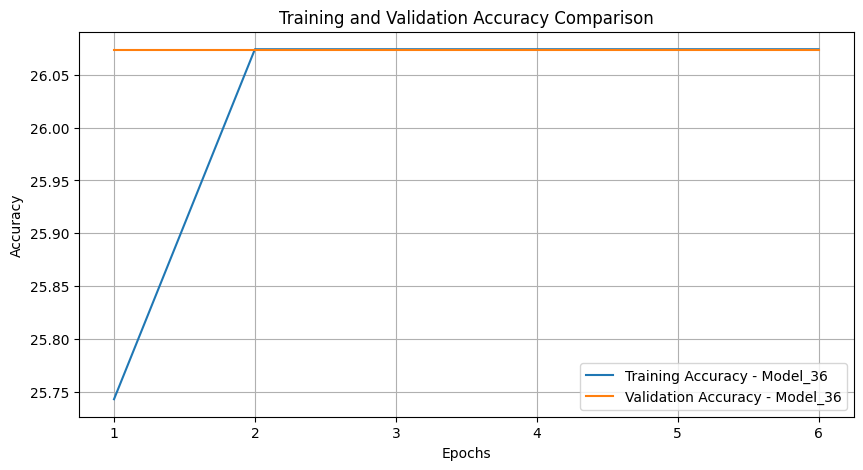

In [41]:
model_name ="Model_36"

# Load the accuracies from the file
with open(f"{model_name}_accuracies.pkl", "rb") as f:
    model_name, train_accuracies, val_accuracies = pickle.load(f)

# Define training results
training_results = [
    (model_name, train_accuracies, val_accuracies)
    # Add more models if needed
]

# Plot the training progress
plot_training_progress(training_results)

#### Train model_37

In [42]:
train_model(model=model_37, model_name="Model_37", criterion=criterion, optimizer=optimizer_21(model_37.parameters()),
            train_loader=train_loader, val_loader=val_loader, device=device,
            num_epochs=200, patience=5, checkpoint_interval=checkpoint_interval)

Epoch [1/200], Loss: 1.755224613738216, Accuracy: 25.890192551408365%
Validation Loss: 1.7524599345202374, Accuracy: 26.073131955484897%
Epoch [2/200], Loss: 1.7523870532029595, Accuracy: 26.07415886513225%
Validation Loss: 1.7522095036385628, Accuracy: 26.073131955484897%
Epoch [3/200], Loss: 1.7521140322965734, Accuracy: 26.07415886513225%
Validation Loss: 1.7517006336734984, Accuracy: 26.073131955484897%
Epoch [4/200], Loss: 1.7521462865904265, Accuracy: 26.07415886513225%
Validation Loss: 1.7522510647168619, Accuracy: 26.073131955484897%
Epoch [5/200], Loss: 1.7519688363168753, Accuracy: 26.07415886513225%
Validation Loss: 1.7515533938625742, Accuracy: 26.073131955484897%
Epoch [6/200], Loss: 1.7514932965920642, Accuracy: 26.07415886513225%
Validation Loss: 1.7516136677737164, Accuracy: 26.073131955484897%
Early stopping at epoch 6. Best validation accuracy: 26.073131955484897%
Best model saved as Model_37_best_model.pth


([1.755224613738216,
  1.7523870532029595,
  1.7521140322965734,
  1.7521462865904265,
  1.7519688363168753,
  1.7514932965920642],
 [25.890192551408365,
  26.07415886513225,
  26.07415886513225,
  26.07415886513225,
  26.07415886513225,
  26.07415886513225],
 [1.7524599345202374,
  1.7522095036385628,
  1.7517006336734984,
  1.7522510647168619,
  1.7515533938625742,
  1.7516136677737164],
 [26.073131955484897,
  26.073131955484897,
  26.073131955484897,
  26.073131955484897,
  26.073131955484897,
  26.073131955484897])

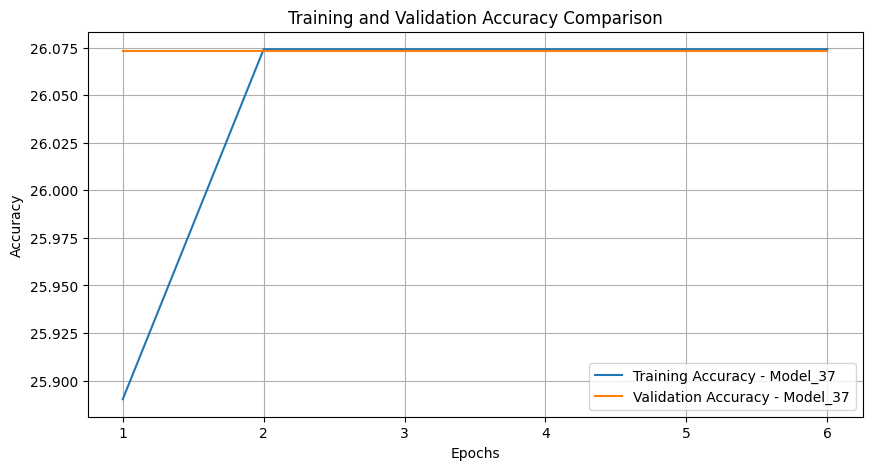

In [43]:
model_name ="Model_37"

# Load the accuracies from the file
with open(f"{model_name}_accuracies.pkl", "rb") as f:
    model_name, train_accuracies, val_accuracies = pickle.load(f)

# Define training results
training_results = [
    (model_name, train_accuracies, val_accuracies)
    # Add more models if needed
]

# Plot the training progress
plot_training_progress(training_results)

#### Model 38

In [17]:
optimizer_23 = lambda params: optim.Adam(params, lr=0.0005, betas=(0.999, 0.999), weight_decay=0.000001)

In [121]:
train_model(model=model_38, model_name="Model_38", criterion=criterion, optimizer=optimizer_23(model_38.parameters()),
            train_loader=train_loader, val_loader=val_loader, device=device,
            num_epochs=200, patience=5, checkpoint_interval=checkpoint_interval)

Epoch [1/200], Loss: 1.9330461610794067, Accuracy: 17.645%
Validation Loss: 1.7784679432205743, Accuracy: 16.82034976152623%
Epoch [2/200], Loss: 1.77396726659139, Accuracy: 21.026666666666667%
Validation Loss: 1.7772002238307507, Accuracy: 18.21939586645469%
Epoch [3/200], Loss: 1.7659945269266764, Accuracy: 22.051666666666666%
Validation Loss: 1.7685149169815373, Accuracy: 21.001589825119236%
Epoch [4/200], Loss: 1.7602650307337444, Accuracy: 22.833333333333332%
Validation Loss: 1.7642697059563575, Accuracy: 22.130365659777425%
Epoch [5/200], Loss: 1.750624185180664, Accuracy: 24.063333333333333%
Validation Loss: 1.7450272474192121, Accuracy: 24.92845786963434%
Epoch [6/200], Loss: 1.73599336643219, Accuracy: 25.25%
Validation Loss: 1.709574606817991, Accuracy: 28.48966613672496%
Epoch [7/200], Loss: 1.725397487258911, Accuracy: 26.11%
Validation Loss: 1.6941196954794946, Accuracy: 29.157392686804453%
Epoch [8/200], Loss: 1.7190901337941487, Accuracy: 26.768333333333334%
Validation L

([1.9330461610794067,
  1.77396726659139,
  1.7659945269266764,
  1.7602650307337444,
  1.750624185180664,
  1.73599336643219,
  1.725397487258911,
  1.7190901337941487,
  1.7116189853668213,
  1.7069294215520223,
  1.701540169843038,
  1.6954043515523274,
  1.692718919436137,
  1.6892182055791218,
  1.6875581970214844,
  1.6855330447514851,
  1.6791454084396362,
  1.675890309079488,
  1.6739331961949666,
  1.669951625696818,
  1.6656840758005778,
  1.6598908439000448,
  1.659521945254008,
  1.658479428990682,
  1.659253488032023,
  1.65094025999705,
  1.6474329355875652,
  1.6423769681930542,
  1.6424370965957642,
  1.6355646469116212,
  1.632652286974589,
  1.6332840355555216,
  1.632377312151591,
  1.6253597164154052,
  1.6306167698542278,
  1.6228613359451294,
  1.6230012199401855,
  1.6206683329900107,
  1.61498069896698,
  1.6153942009607951,
  1.6157222448984783,
  1.6124169014612835,
  1.6055137648264568,
  1.602535413678487,
  1.5999400183995565,
  1.600867995071411,
  1.60095

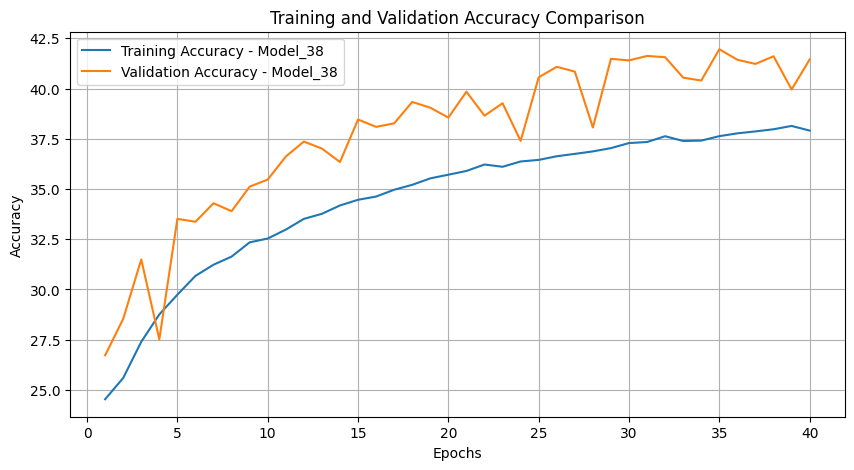

In [115]:
model_name ="Model_38"

# Load the accuracies from the file
with open(f"{model_name}_accuracies.pkl", "rb") as f:
    model_name, train_accuracies, val_accuracies = pickle.load(f)

# Define training results
training_results = [
    (model_name, train_accuracies, val_accuracies)
    # Add more models if needed
]

# Plot the training progress
plot_training_progress(training_results)

#### Model 39

Even if it's not avisable, let's remove the dropout layers from model 38 to help reducing the underfitting.

In [20]:
train_model(model=model_39, model_name="Model_39", criterion=criterion, optimizer=optimizer_23(model_39.parameters()),
            train_loader=train_loader, val_loader=val_loader, device=device,
            num_epochs=200, patience=5, checkpoint_interval=checkpoint_interval)

Epoch [1/200], Loss: 1.756693760172526, Accuracy: 22.883333333333333%
Validation Loss: 1.7193624918836021, Accuracy: 27.344992050874403%
Epoch [2/200], Loss: 1.7427812165578207, Accuracy: 24.47%
Validation Loss: 1.7276672838908163, Accuracy: 27.440381558028616%
Epoch [3/200], Loss: 1.7267474919001262, Accuracy: 26.143333333333334%
Validation Loss: 1.72349170137783, Accuracy: 27.82193958664547%
Epoch [4/200], Loss: 1.712651548322042, Accuracy: 27.42%
Validation Loss: 1.6792340986619747, Accuracy: 30.476947535771064%
Epoch [5/200], Loss: 1.702801729774475, Accuracy: 28.203333333333333%
Validation Loss: 1.6658790704562578, Accuracy: 31.12877583465819%
Epoch [6/200], Loss: 1.6892300443649293, Accuracy: 29.033333333333335%
Validation Loss: 1.6454869526896985, Accuracy: 32.17806041335453%
Epoch [7/200], Loss: 1.6760879220962523, Accuracy: 29.965%
Validation Loss: 1.645338287208286, Accuracy: 32.829888712241655%
Epoch [8/200], Loss: 1.6588218918482462, Accuracy: 31.211666666666666%
Validation

([1.756693760172526,
  1.7427812165578207,
  1.7267474919001262,
  1.712651548322042,
  1.702801729774475,
  1.6892300443649293,
  1.6760879220962523,
  1.6588218918482462,
  1.6465349847157795,
  1.632932227198283,
  1.615481056022644,
  1.6131983252207438,
  1.6022833124160767,
  1.5897284368515014,
  1.5832009429931642,
  1.5902910807291666,
  1.5829732315699259,
  1.5772694498062134,
  1.563120783996582,
  1.5470784936904907,
  1.5384132031122844,
  1.539623777071635,
  1.5470291462580363,
  1.5455795229593914,
  1.5268723901748658,
  1.5229502332687377,
  1.5233562267303467,
  1.5139644108454386,
  1.5101679741541545,
  1.508330385462443,
  1.492129390780131,
  1.4908236607869467,
  1.4926649960835774,
  1.4845404373168944,
  1.4780790428797403,
  1.4740367687861125,
  1.4673985674540202,
  1.4598456919670104,
  1.4623176719665527,
  1.473691919517517,
  1.4618827999750774,
  1.4555307526906331,
  1.4505312130610148],
 [22.883333333333333,
  24.47,
  26.143333333333334,
  27.42,
 

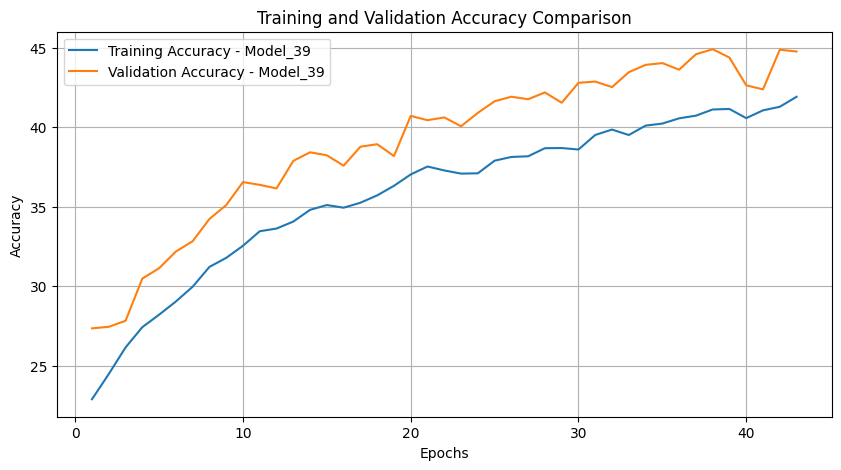

In [21]:
model_name ="Model_39"

# Load the accuracies from the file
with open(f"{model_name}_accuracies.pkl", "rb") as f:
    model_name, train_accuracies, val_accuracies = pickle.load(f)

# Define training results
training_results = [
    (model_name, train_accuracies, val_accuracies)
    # Add more models if needed
]

# Plot the training progress
plot_training_progress(training_results)

Performance looks much better now. However, as model 38, validation accuracy remains higher that training accuracy, because the training set is more complex than the validation set. This means, that by increasing patience, the model might train even more until the training accuarcy surpasses the validation accuracy.

### Test the models

#### Test model_26

In [104]:
model_name = "Model 26"
evaluate_model(model_26, criterion, test_loader, device, model_name)

(1.7903808120525244, 26.061039580352887)

#### Test model_33

In [116]:
model_name = "Model 33"
evaluate_model(model_33, criterion, test_loader, device, model_name)

(1.1609775080825344, 54.53028135431569)

#### Test model_36

In [46]:
model_name = "Model 36"
evaluate_model(model_36, criterion, test_loader, device, model_name)

(1.7517969635399906, 26.061039580352887)

#### Test model_37

In [47]:
model_name = "Model 37"
evaluate_model(model_37, criterion, test_loader, device, model_name)

(1.7516889147686237, 26.061039580352887)

#### Test model_38

In [122]:
model_name = "Model 38"
evaluate_model(model_38, criterion, test_loader, device, model_name)

(1.5665599712819764, 37.02908917501192)

#### Test model_39

In [22]:
model_name = "Model 39"
evaluate_model(model_39, criterion, test_loader, device, model_name)

(1.386819924369003, 44.897472579876016)

We can see that every model apart from model 33, 38, and 39 was too complex and underfit the data.

We did not do much hypeparameter tuning on the optimizers, but we will do so in the next notebook.

### Table with the results of the different models

Before making our table we want to inspect the structure of the pickle files where we saved our accuracies. In this way we will know how to load the data.

In [23]:
# Function to inspect the structure of the pickle file
def inspect_pickle_file(pickle_file):
    with open(pickle_file, 'rb') as f:
        data = pickle.load(f)
    print(f"Data from {pickle_file}:")
    print(data)
    return data

# Inspect one of the pickle files with the accuracies
sample_file_1 = 'Model_39_accuracies.pkl'
sample_file_2 = 'Model 39_test_results.pkl'
data_1 = inspect_pickle_file(sample_file_1)
data_2 = inspect_pickle_file(sample_file_2)

Data from Model_39_accuracies.pkl:
('Model_39', [22.883333333333333, 24.47, 26.143333333333334, 27.42, 28.203333333333333, 29.033333333333335, 29.965, 31.211666666666666, 31.78, 32.541666666666664, 33.45666666666666, 33.625, 34.065, 34.803333333333335, 35.105, 34.93833333333333, 35.25, 35.71333333333333, 36.315, 37.031666666666666, 37.53, 37.28333333333333, 37.083333333333336, 37.10166666666667, 37.89666666666667, 38.13166666666667, 38.175, 38.68333333333333, 38.693333333333335, 38.6, 39.516666666666666, 39.85666666666667, 39.51166666666666, 40.105, 40.233333333333334, 40.56333333333333, 40.73, 41.12, 41.151666666666664, 40.575, 41.065, 41.29, 41.91833333333334], [27.344992050874403, 27.440381558028616, 27.82193958664547, 30.476947535771064, 31.12877583465819, 32.17806041335453, 32.829888712241655, 34.22893481717011, 35.1033386327504, 36.550079491255964, 36.37519872813991, 36.15262321144674, 37.88553259141494, 38.426073131955484, 38.23529411764706, 37.58346581875993, 38.7758346581876, 

#### Load the data from the pickle files

In [36]:
# Function to load pickle file and get the highest accuracy
def get_best_accuracies(pickle_file):
    with open(pickle_file, 'rb') as f:
        data = pickle.load(f)
    # Data is a tuple (model_name, training_accuracies, validation_accuracies)
    model_name, training_accuracies, validation_accuracies = data
    best_training_accuracy = max(training_accuracies)
    best_validation_accuracy = max(validation_accuracies)
    return best_training_accuracy, best_validation_accuracy

# Function to load pickle file and get the test accuracy and test loss
def get_test_results(pickle_file):
    with open(pickle_file, 'rb') as f:
        data = pickle.load(f)
    # Data is a dictionary with 'test_accuracy' and 'test_losses' keys
    test_accuracy = data['test_accuracy']
    test_loss = data['test_loss']
    return test_accuracy, test_loss

# Load pickle files for each model
val_train_results = [
    'Model_33_accuracies.pkl',
    'Model_38_accuracies.pkl',
    'Model_39_accuracies.pkl'

]

# Load test results for each model
test_results = [
    'Model 33_test_results.pkl',
    'Model 38_test_results.pkl',
    'Model 39_test_results.pkl'
]

# Load accuracies and test losses for each model
training_accuracies = []
validation_accuracies = []
test_accuracies = []
test_losses = []

for i, file in enumerate(val_train_results):
    train_acc, val_acc = get_best_accuracies(file)
    training_accuracies.append(train_acc)
    validation_accuracies.append(val_acc)
    test_acc, test_loss = get_test_results(test_results[i])
    test_accuracies.append(test_acc)
    test_losses.append(test_loss)

# Model names or identifiers (we are adding a +9 because our models start from #10)
model_names = [f"Model {32+i+1}" for i in range(len(val_train_results))]

# Print the accuracies and test losses
print("Training Accuracies:", training_accuracies)
print("Validation Accuracies:", validation_accuracies)
print("Test Accuracies:", test_accuracies)
print("Test Losses:", test_losses)



Training Accuracies: [51.303333333333335, 34.1, 41.91833333333334]
Validation Accuracies: [54.213036565977745, 37.011128775834656, 44.912559618441975]
Test Accuracies: [54.53028135431569, 37.02908917501192, 44.897472579876016]
Test Losses: [1.1609775080825344, 1.5665599712819764, 1.386819924369003]


As we can see our best model so far is mdoel 33, but by using grid search or random search also the other two models might improve significantly through hyperparameters tuning.

#### Print the table

In [37]:
# Creating the DataFrame
data = {
    "Model": model_names,
    "Training Accuracy": training_accuracies,
    "Validation Accuracy": validation_accuracies,
    "Test Accuracy": test_accuracies,
    "Test Loss": test_losses
}

df = pd.DataFrame(data)

# Display the DataFrame
print(df)

      Model  Training Accuracy  Validation Accuracy  Test Accuracy  Test Loss
0  Model 33          51.303333            54.213037      54.530281   1.160978
1  Model 34          34.100000            37.011129      37.029089   1.566560
2  Model 35          41.918333            44.912560      44.897473   1.386820


### Confusion matrix of the best models

#### Model 33

In [26]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        # Define the layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(p=0.5)
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.dropout2 = nn.Dropout(p=0.5)
        
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        
        self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(256)
        self.dropout3 = nn.Dropout(p=0.5)
        
        self.fc1 = nn.Linear(256 * 6 * 6, 128)
        self.bn7 = nn.BatchNorm1d(128)
        self.dropout4 = nn.Dropout(p=0.5)
        
        self.out = nn.Linear(128, 6)  # Change the number of output channels to 8
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.dropout1(x)
        
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)
        x = self.dropout2(x)
        
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.pool(x)
        x = self.dropout3(x)
        
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = F.relu(self.bn7(self.fc1(x)))
        x = self.dropout4(x)
        x = self.out(x)
        
        return x

In [27]:
# Load the best model weights
model_path = 'Model_33_best_model.pth'
model_33 = CNNModel()
model_33.load_state_dict(torch.load(model_path))
model_33.eval()

CNNModel(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.5, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_

In [28]:
# Select between 'cpu' or 'cuda' to access GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# Move the model to the selected device
model_33.to(device)

# Summarize the model
summary(model_33, input_size=(1, 48, 48), batch_size=1, device=device)

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [1, 64, 48, 48]             640
       BatchNorm2d-2            [1, 64, 48, 48]             128
            Conv2d-3            [1, 64, 48, 48]          36,928
       BatchNorm2d-4            [1, 64, 48, 48]             128
         MaxPool2d-5            [1, 64, 24, 24]               0
           Dropout-6            [1, 64, 24, 24]               0
            Conv2d-7           [1, 128, 24, 24]          73,856
       BatchNorm2d-8           [1, 128, 24, 24]             256
            Conv2d-9           [1, 128, 24, 24]         147,584
      BatchNorm2d-10           [1, 128, 24, 24]             256
        MaxPool2d-11           [1, 128, 12, 12]               0
          Dropout-12           [1, 128, 12, 12]               0
           Conv2d-13           [1, 256, 12, 12]         295,168
      BatchNorm2d-14           [1,

In [31]:
true_labels = []
predicted_labels = []

#Re-define val_loader
val_loader = DataLoader(val_tensors, batch_size=32, shuffle=False)

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_33(images)
        _, preds = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())  # Move to CPU before converting to numpy
        predicted_labels.extend(preds.cpu().numpy())  # Move to CPU before converting to numpy

true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)


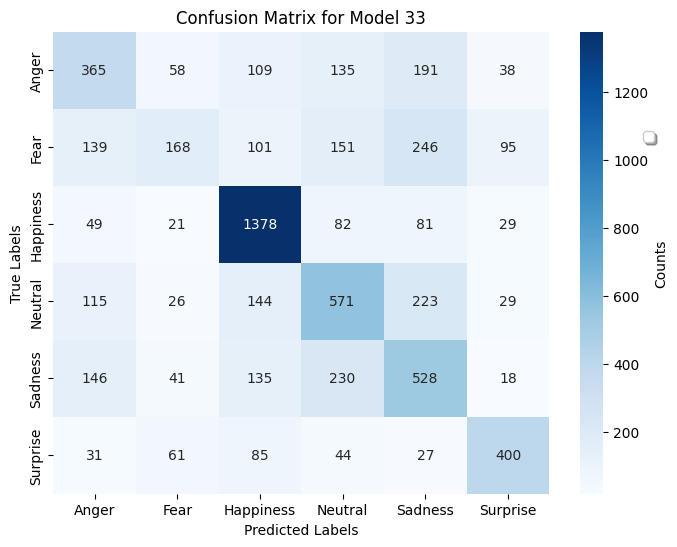

In [33]:
#Specify the model (for the title)
model_name = "Model 33"

# Label mapping
label_mapping = {
    0: 'Anger',
    1: 'Fear',
    2: 'Happiness',
    3: 'Neutral',
    4: 'Sadness',
    5: 'Surprise'
}

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_mapping.values(), yticklabels=label_mapping.values())

plt.title(f'Confusion Matrix for {model_name}')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

#Get the current Axes object from the plot
ax = plt.gca()

# Create a colorbar based on the mappable (heatmap)
cbar = ax.collections[0].colorbar
cbar.set_label('Counts')

# Add legend
plt.legend(label_mapping.values(), loc='upper center', bbox_to_anchor=(1.2, 0.8), shadow=True, ncol=1)

plt.show()

It looks like the model is having problem in identifyng fear, especially it missclissifies fear for anger, happiness, neutrality, and especially sadness. Mistaking fear for happiness shouldn't be happening, since the two emotions have very different representations so the model has a huge margin of improvement.

## Conclusions

### Observations

Our best models were:
- [Model 33](#model-33): Training Acc: 51.303333, Vall Acc: 54.213037, Test Acc: 54.530281, Test loss: 1.160978
- [Model 38](#model-38): Training Acc: 34.100000, Vall Acc: 37.011129, Test Acc: 37.029089, Test loss: 1.566560
- [Model 39](#model-39): Training Acc: 41.918333, Vall Acc: 44.912560, Test Acc: 44.897473, Test loss: 1.386820

As we can see Model 33 learn significantly more, it has a higher test accuracy and lower test loss. The model has also doesn't overfit the data. The other two models don't have an accettable performance for now, but some hyperparameters tuning on the optimizer may lead to much better performance.

The accuracy of these models is not stellar, however, considering that it's an image classification task comprehending 6 classes, every error and missclassification compound and greatly reduce accuracy. If the task would have been a binary or ternary classification (with some small tweaks in the output channels), it would have performed much better. Moreover, some classes were hard to distinguish sometimes, both because of the data and because they are tricky to distinguish also for humans (sadness Vs neutrality, anger Vs neutrality, anger Vs fear, fear Vs surprise), also because the presence of mixed emotions and reliance on microexpressions.

Accordingly the most interesting results were found in the analysis of the confusions matrices though, and [you can find them here](#confusion-matrix-of-the-best-models).

### Lessons learned

We trained and tested 8 separate model to find out that:
1. Adding too many hidden layers reduced the performance of the model, but adding none made the model more prone to overfitting.
2. Reducing the number of convolutional layers reduced the test accuracy.
3. We tried 0.1, 0.25, and 0.5 dropout rates, and 0.25 worked best in our models.
4. Hyperparameter tuning was fundamental in improving the performance of our models. We slightly increased the learning rate to improve the model converge, even if it lead to lower stability. On the other hand, we incremented significantly the weight decay. We also increased beta 1 to give some momentum to the model and avoid having it stuck into a local minima.

In the future we should considering using random search at first and then grid search to automatically fine tune hyperparamentes. Indeed, this is what took the most time, and finetuning hyperparameters that way would have saved us many tests. Moreover, if we have greatly improved our models' performance and explored several combinations, we have probably haven't reached the best hypermarameters combination for the optimizer. We have not implemented random or greed search because a CNN for image classificaton can be computationally expensive to fine tune that way, especially if we consider grid search.

We have trained different models of different complexities and we found out that more complex models don't necessarily perform better for our dataset.
Another hyperparameter we fine tuned is patience. We found out that patience worked best at 10, even if we trained some models with 20 patience, because they had a higher weight decay and were slower to train. However, increasing patience leads also to more overfittin.

### Limitations with the data

The data is one of the  major bottlenecks in this experiemnt. As said in the first notebook of the series, if there are missclassified images in the original data, that may lead to errors in the training. Also, mixed emotions (e.g., surprise + fear, surprise + happiness) can confuse the model as well. Also the fact that some emotions have similar traits made the learning process more difficult (e.g., Neutral Vs Sadness), and it would be useful to use this generic model as a base model to train more specialized models aimed at detecting the difference between such emotions (through the identification of microexpressions).

Another challenge was that the majority of images were images portraing actors interpreting an emotion. While it looks like the majortiy of good actors did a good job in displaying the emotion, some representation may not have looked authentic, with incomplete and to genuine microexpressions. To reduce the risk of encountering these two challenges we could access to bigger datasets (to increasing the chance of good samples outnumbering bad samples), and higher quality more controlled datasets. A further study could also take the output model from this study and use it as a pre-trained model to classify genuine Vs faked emotions from pictures.

When loading the data we removed duplicates, mixed data from different sources (increasing the variance in gender, etnic diversity, angles, and styles), and augmented data to reduce overfitting and balance the classes, so each class got the same amount of items. However, we did not aumented the images from the "Happiness" folder, because it had the most items, so further study could do some augmentation there too to reduce overfitting (still making sure that each label has the same number of items).

As future steps we should try adding more images through data augmentation, and test if that helps in reducing overfitting. We could also experiment removing neutrality, our most mistaken class (mistaken for sadness and viceversa), and see how accuracy dramatically increases. However, by removing a class, we would also drastically change the goal of our models. Also, by removing neutrality, if the model was to be applied in a life scenarion, it would start mistake neutral expression for sadness.

### Next steps

To summarise our next steps, we should defenitely try to use random seach and or grid search to fine tune hyperparameters, since they have such a big impact on the training process. We should also try stratified k fold cross validation. Moreover, we might try stopping the training once the training accuracy surpasses the validation accuracy.